### **Kalp Hastalığı Tahmin Modeli**

In [1]:
import warnings
warnings.filterwarnings('ignore')

# data wrangling & pre-processing
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve


#model validation
from sklearn.metrics import log_loss,roc_auc_score,precision_score,f1_score,recall_score,roc_curve,auc
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,fbeta_score,matthews_corrcoef
from sklearn import metrics

# cross validation
from sklearn.model_selection import StratifiedKFold

# machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.svm import SVC 
#import xgboost as xgb

from scipy import stats

from my_lib import *
import joblib 

df = pd.read_csv('heart_statlog_cleveland_hungary_final.csv')

display(df)

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1185,45,1,1,110,264,0,0,132,0,1.2,2,1
1186,68,1,4,144,193,1,0,141,0,3.4,2,1
1187,57,1,4,130,131,0,0,115,1,1.2,2,1
1188,57,0,2,130,236,0,2,174,0,0.0,2,1


In [2]:
df.columns = [col.upper() for col in df.columns]

In [3]:
def create_readable_dataframe(df):
    df2 = df.copy()

    df2['CHEST PAIN TYPE'][df2['CHEST PAIN TYPE'] == 1] = 'typical angina'
    df2['CHEST PAIN TYPE'][df2['CHEST PAIN TYPE'] == 2] = 'atypical angina'
    df2['CHEST PAIN TYPE'][df2['CHEST PAIN TYPE'] == 3] = 'non-anginal pain'
    df2['CHEST PAIN TYPE'][df2['CHEST PAIN TYPE'] == 4] = 'asymptomatic'

    df2['RESTING ECG'][df2['RESTING ECG'] == 0] = 'normal'
    df2['RESTING ECG'][df2['RESTING ECG'] == 1] = 'ST-T wave abnormality'
    df2['RESTING ECG'][df2['RESTING ECG'] == 2] = 'left ventricular hypertrophy'

    df2['ST SLOPE'][df2['ST SLOPE'] == 1] = 'upsloping'
    df2['ST SLOPE'][df2['ST SLOPE'] == 2] = 'flat'
    df2['ST SLOPE'][df2['ST SLOPE'] == 3] = 'downsloping'

    df2["SEX"] = df2.SEX.apply(lambda  x:'male' if x==1 else 'female')

    df2["FASTING BLOOD SUGAR"] = df2["FASTING BLOOD SUGAR"].apply(lambda  x:'normal' if x==0 else 'high')

    df2['EXERCISE ANGINA'] = df2['EXERCISE ANGINA'].map({0: 'False', 1: 'True'}).astype('category')

    df2['TARGET'] = df2['TARGET'].map({0: 'Healthy', 1: 'Disease'}).astype('category')

    return df2

df2 = create_readable_dataframe(df)

In [4]:
DataFrame_Summary(df2, "Heart Disease")

Observations: 1190
Variables: 12 

----------------------- 
Heart Disease DATAFRAME 
-----------------------
---- 
Head 
----


,AGE,SEX,CHEST PAIN TYPE,RESTING BP S,CHOLESTEROL,FASTING BLOOD SUGAR,RESTING ECG,MAX HEART RATE,EXERCISE ANGINA,OLDPEAK,ST SLOPE,TARGET
0,40,male,atypical angina,140,289,normal,normal,172,False,0.0,upsloping,Healthy
1,49,female,non-anginal pain,160,180,normal,normal,156,False,1.0,flat,Disease
2,37,male,atypical angina,130,283,normal,ST-T wave abnormality,98,False,0.0,upsloping,Healthy
3,48,female,asymptomatic,138,214,normal,normal,108,True,1.5,flat,Disease
4,54,male,non-anginal pain,150,195,normal,normal,122,False,0.0,upsloping,Healthy


---- 
Tail 
----


,AGE,SEX,CHEST PAIN TYPE,RESTING BP S,CHOLESTEROL,FASTING BLOOD SUGAR,RESTING ECG,MAX HEART RATE,EXERCISE ANGINA,OLDPEAK,ST SLOPE,TARGET
1185,45,male,typical angina,110,264,normal,normal,132,False,1.2,flat,Disease
1186,68,male,asymptomatic,144,193,high,normal,141,False,3.4,flat,Disease
1187,57,male,asymptomatic,130,131,normal,normal,115,True,1.2,flat,Disease
1188,57,female,atypical angina,130,236,normal,left ventricular hypertrophy,174,False,0.0,flat,Disease
1189,38,male,non-anginal pain,138,175,normal,normal,173,False,0.0,upsloping,Healthy


----------------- 
Categoric Columns 
-----------------
CHEST PAIN TYPE          object
EXERCISE ANGINA        category
FASTING BLOOD SUGAR      object
RESTING ECG              object
SEX                      object
ST SLOPE                 object
TARGET                 category
dtype: object 

-------------------------------------------- 
Descriptive Statistics for Categoric Columns 
--------------------------------------------


,count,unique,top,freq
CHEST PAIN TYPE,1190,4,asymptomatic,625
EXERCISE ANGINA,1190,2,False,729
FASTING BLOOD SUGAR,1190,2,normal,936
RESTING ECG,1190,3,normal,684
SEX,1190,2,male,909
ST SLOPE,1190,4,flat,582
TARGET,1190,2,Disease,629



--------------- 
Numeric Columns 
---------------
AGE                 int64
CHOLESTEROL         int64
MAX HEART RATE      int64
OLDPEAK           float64
RESTING BP S        int64
dtype: object 

------------------------------------------ 
Descriptive Statistics for Numeric Columns 
------------------------------------------


,count,mean,std,min,25%,50%,75%,max
AGE,1190.0,53.720168,9.358203,28.0,47.0,54.0,60.00,77.0
CHOLESTEROL,1190.0,210.363866,101.420489,0.0,188.0,229.0,269.75,603.0
MAX HEART RATE,1190.0,139.732773,25.517636,60.0,121.0,140.5,160.00,202.0
OLDPEAK,1190.0,0.922773,1.086337,-2.6,0.0,0.6,1.60,6.2
RESTING BP S,1190.0,132.153782,18.368823,0.0,120.0,130.0,140.00,200.0



---------------- 
Cardinal Columns 
----------------
There is not any Cardinal Columns in the dataframe.



In [5]:
cat_cols, num_cols, car_cols = grab_col_names(df)

##### *Kategorik Değişken Analizi (Analysis of Categorical Variables)*

In [6]:
df.columns

Index(['AGE', 'SEX', 'CHEST PAIN TYPE', 'RESTING BP S', 'CHOLESTEROL',
       'FASTING BLOOD SUGAR', 'RESTING ECG', 'MAX HEART RATE',
       'EXERCISE ANGINA', 'OLDPEAK', 'ST SLOPE', 'TARGET'],
      dtype='object')

------------------- 
Categorical Columns 
-------------------
--------------- 
CHEST PAIN TYPE 
---------------


,CHEST PAIN TYPE,Ratio
4,625,52.521008
3,283,23.781513
2,216,18.151261
1,66,5.546218


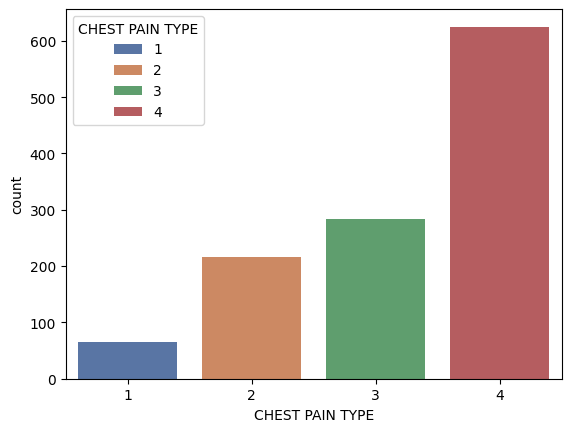


--------------- 
EXERCISE ANGINA 
---------------


,EXERCISE ANGINA,Ratio
0,729,61.260504
1,461,38.739496


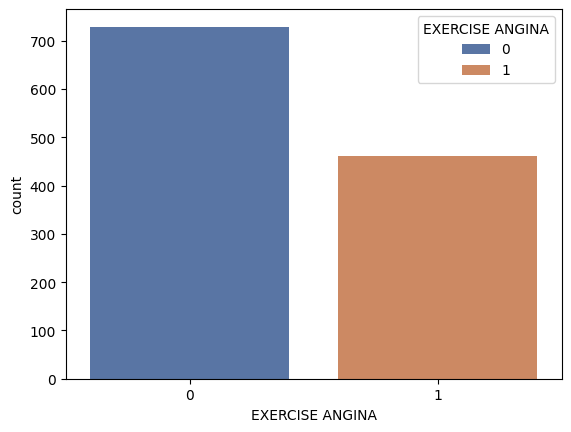


------------------- 
FASTING BLOOD SUGAR 
-------------------


,FASTING BLOOD SUGAR,Ratio
0,936,78.655462
1,254,21.344538


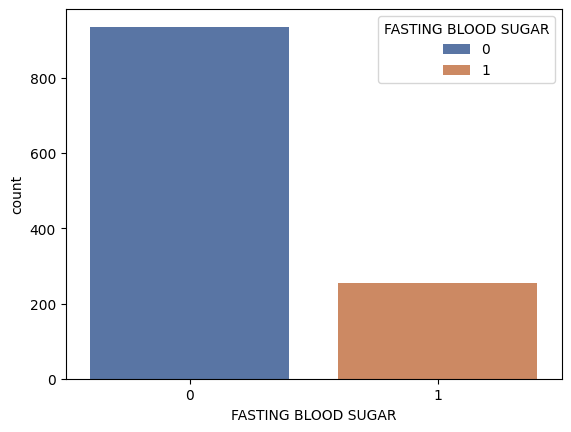


----------- 
RESTING ECG 
-----------


,RESTING ECG,Ratio
0,684,57.478992
2,325,27.310924
1,181,15.210084


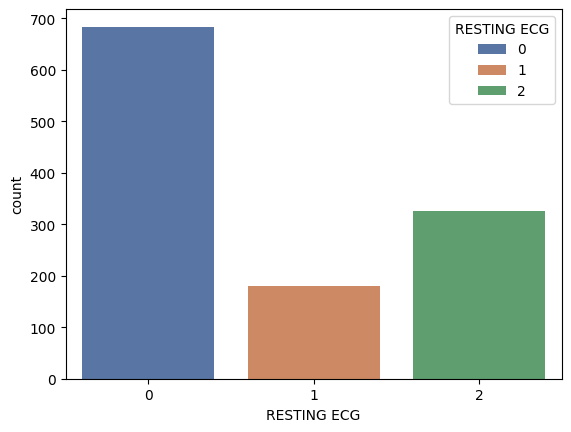


--- 
SEX 
---


,SEX,Ratio
1,909,76.386555
0,281,23.613445


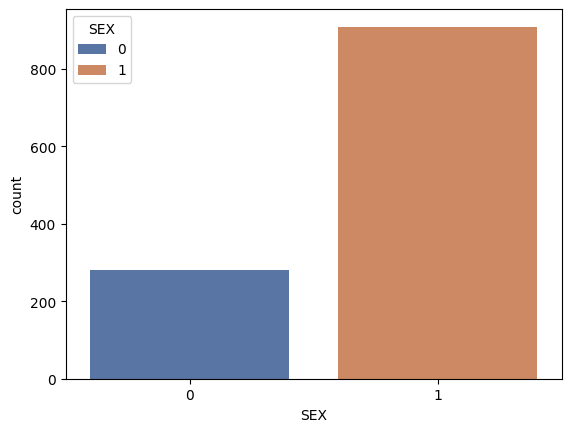


-------- 
ST SLOPE 
--------


,ST SLOPE,Ratio
2,582,48.907563
1,526,44.201681
3,81,6.806723
0,1,0.084034


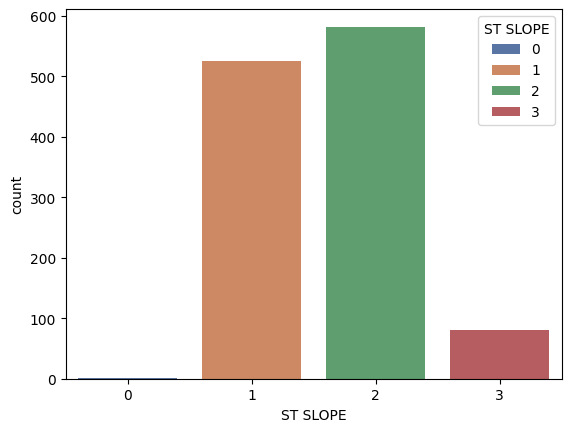


------ 
TARGET 
------


,TARGET,Ratio
1,629,52.857143
0,561,47.142857


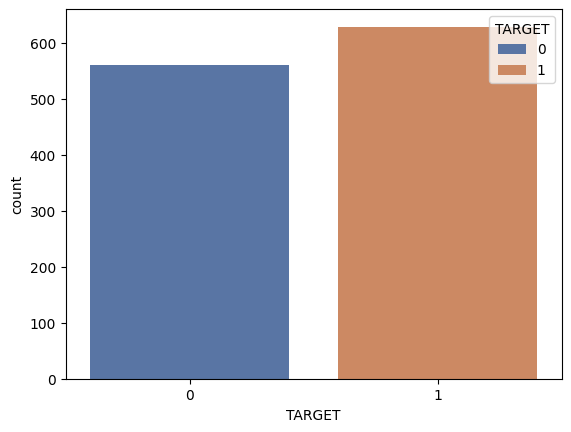

In [7]:
printTitle("Categorical Columns")
for col in cat_cols:
    printTitle(col)
    cat_col_summary(df, col, plot=True)
    print()

##### *Sayısal Değişken Analizi (Analysis of Numerical Variables)*

----------------- 
Numerical Columns 
-----------------
--- 
AGE 
---


,AGE
count,1190.000000
mean,53.720168
std,9.358203
min,28.000000
0%,28.000000
5%,38.000000
25%,47.000000
50%,54.000000
75%,60.000000
95%,68.000000


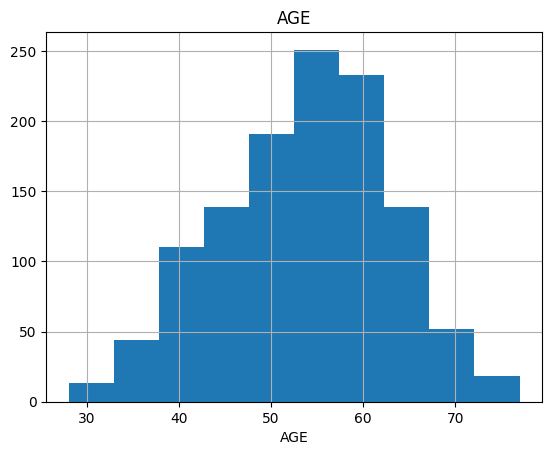


----------- 
CHOLESTEROL 
-----------


,CHOLESTEROL
count,1190.000000
mean,210.363866
std,101.420489
min,0.000000
0%,0.000000
5%,0.000000
25%,188.000000
50%,229.000000
75%,269.750000
95%,330.000000


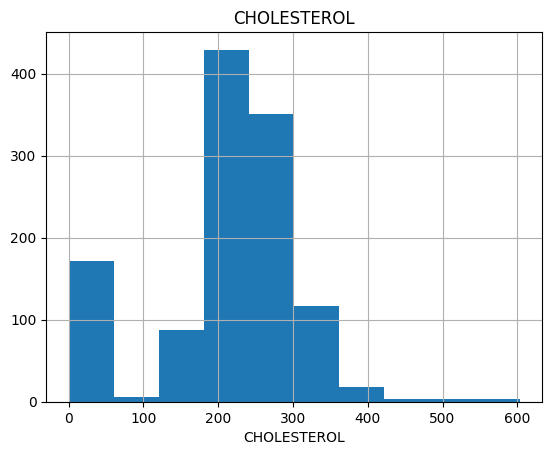


-------------- 
MAX HEART RATE 
--------------


,MAX HEART RATE
count,1190.000000
mean,139.732773
std,25.517636
min,60.000000
0%,60.000000
5%,97.000000
25%,121.000000
50%,140.500000
75%,160.000000
95%,179.000000


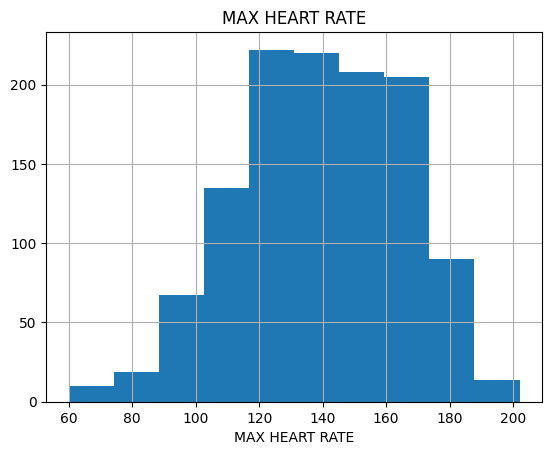


------- 
OLDPEAK 
-------


,OLDPEAK
count,1190.000000
mean,0.922773
std,1.086337
min,-2.600000
0%,-2.600000
5%,0.000000
25%,0.000000
50%,0.600000
75%,1.600000
95%,3.000000


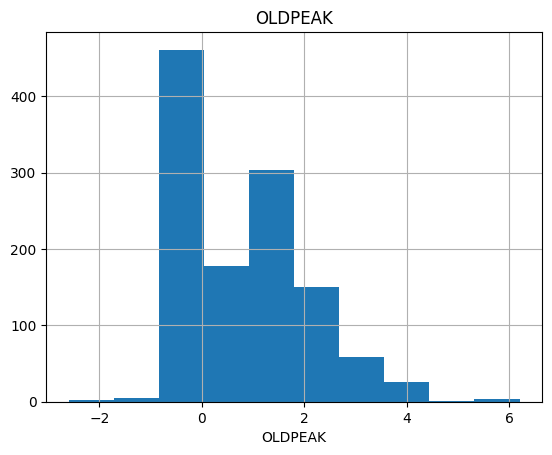


------------ 
RESTING BP S 
------------


,RESTING BP S
count,1190.000000
mean,132.153782
std,18.368823
min,0.000000
0%,0.000000
5%,106.000000
25%,120.000000
50%,130.000000
75%,140.000000
95%,160.000000


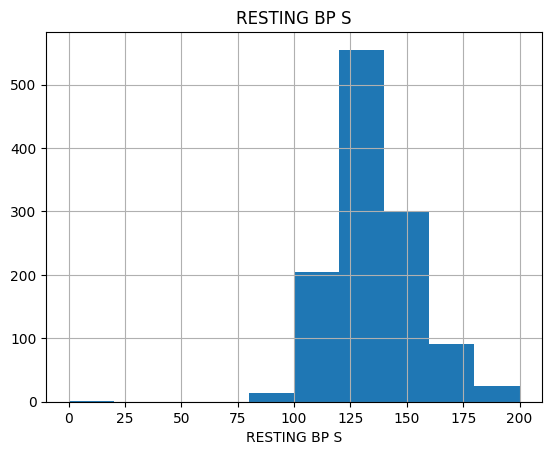

In [8]:
printTitle("Numerical Columns")
for col in num_cols:
    printTitle(col)
    num_col_summary(df, col, plot=True)
    print()

##### *Hedef Değişken Analizi (Analysis of Target Variable)*

------------------------------------- 
Target Summary with Numerical Columns 
-------------------------------------
--- 
AGE 
---


,AGE
TARGET,
Disease,56.034976
Healthy,51.124777


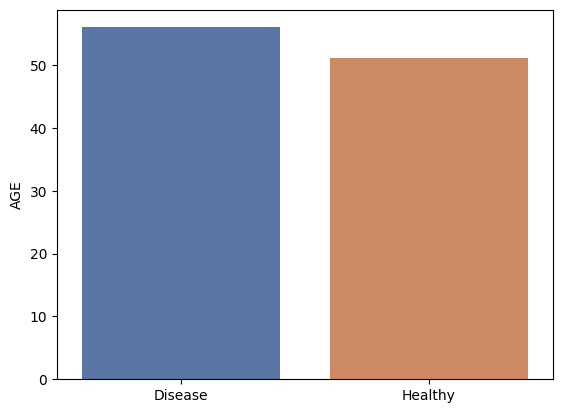


----------- 
CHOLESTEROL 
-----------


,CHOLESTEROL
TARGET,
Disease,191.372019
Healthy,231.657754


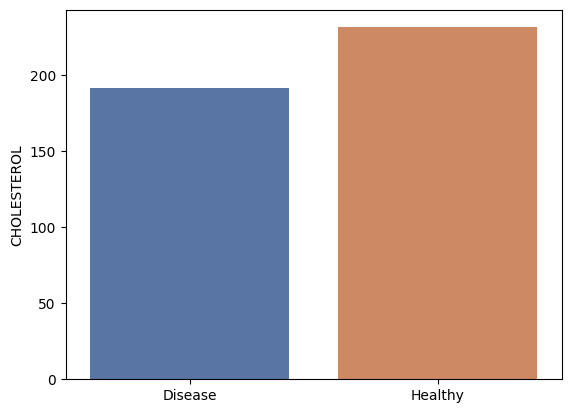


-------------- 
MAX HEART RATE 
--------------


,MAX HEART RATE
TARGET,
Disease,129.777424
Healthy,150.894831


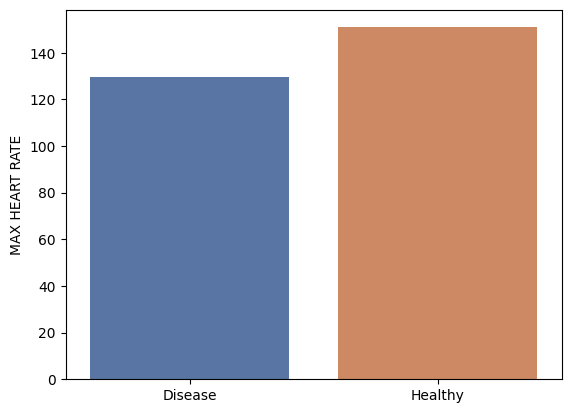


------- 
OLDPEAK 
-------


,OLDPEAK
TARGET,
Disease,1.331320
Healthy,0.464706


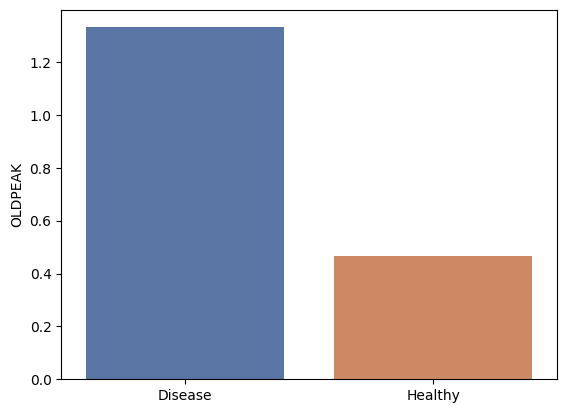


------------ 
RESTING BP S 
------------


,RESTING BP S
TARGET,
Disease,134.259141
Healthy,129.793226


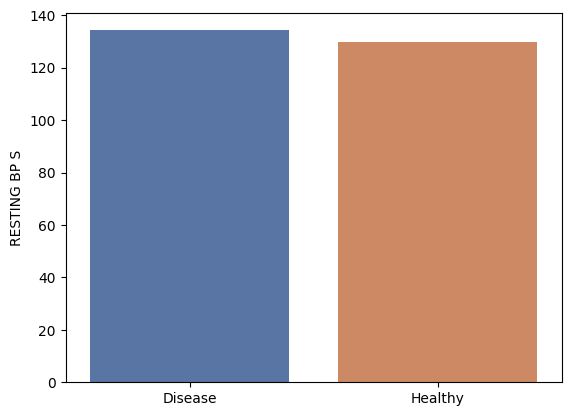

In [9]:
printTitle("Target Summary with Numerical Columns")
for col in num_cols:
    target_summary_with_num(df2, "TARGET", col, plot=True)
    print()

--------------------------------------- 
Target Summary with Categorical Columns 
---------------------------------------
--------------- 
CHEST PAIN TYPE 
---------------


,Disease Mean,Count,Ratio
asymptomatic,0.772800,625,52.521008
atypical angina,0.143519,216,18.151261
non-anginal pain,0.318021,283,23.781513
typical angina,0.378788,66,5.546218


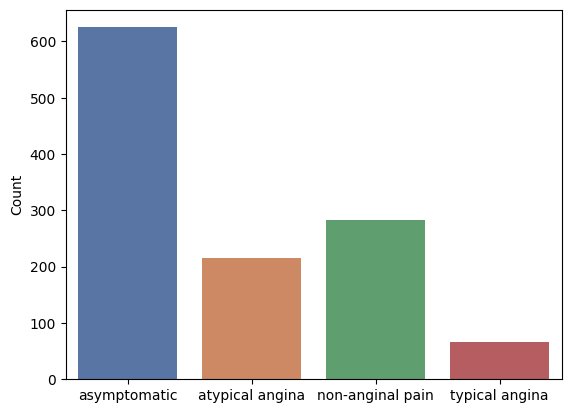


--------------- 
EXERCISE ANGINA 
---------------


,Disease Mean,Count,Ratio
False,0.337449,729,61.260504
True,0.830803,461,38.739496


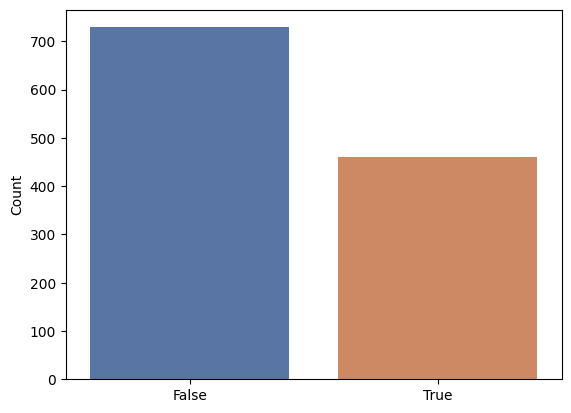


------------------- 
FASTING BLOOD SUGAR 
-------------------


,Disease Mean,Count,Ratio
high,0.736220,254,21.344538
normal,0.472222,936,78.655462


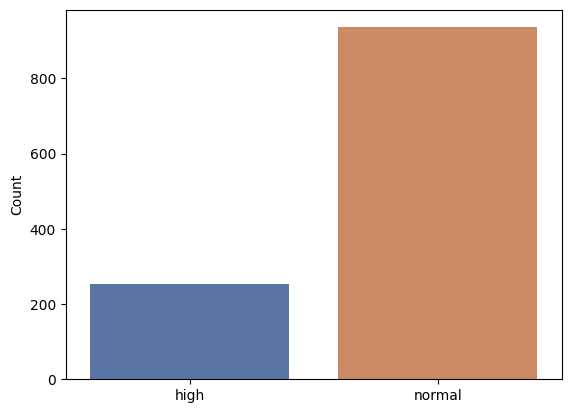


----------- 
RESTING ECG 
-----------


,Disease Mean,Count,Ratio
ST-T wave abnormality,0.657459,181,15.210084
left ventricular hypertrophy,0.550769,325,27.310924
normal,0.483918,684,57.478992


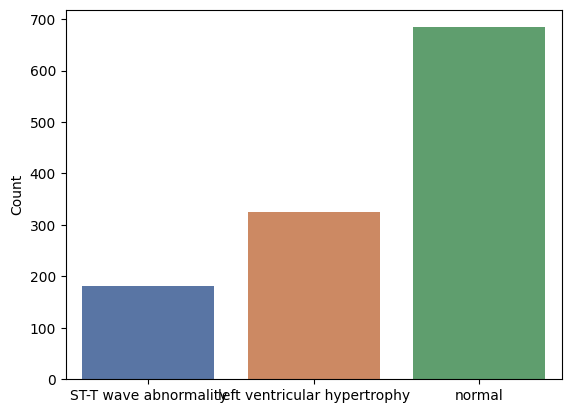


--- 
SEX 
---


,Disease Mean,Count,Ratio
female,0.249110,281,23.613445
male,0.614961,909,76.386555


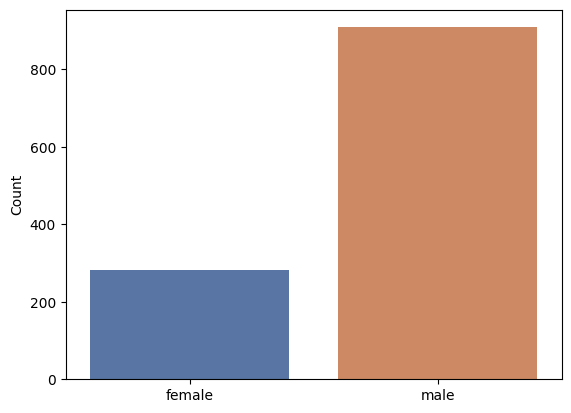


-------- 
ST SLOPE 
--------


,Disease Mean,Count,Ratio
0,1.000000,1,0.084034
downsloping,0.728395,81,6.806723
flat,0.788660,582,48.907563
upsloping,0.209125,526,44.201681


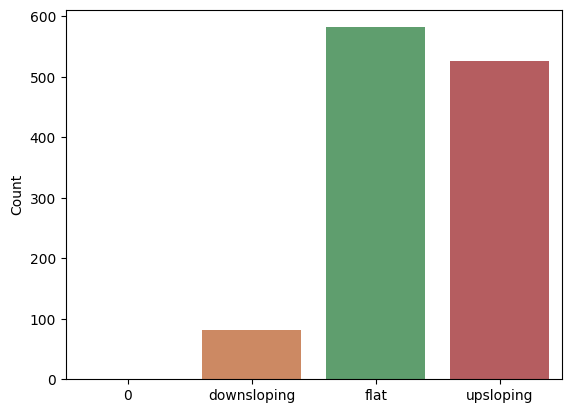

In [10]:
df2["TARGET INT"] = df["TARGET"]

printTitle("Target Summary with Categorical Columns")
for col in cat_cols[:-1]:
    target_summary_with_cat(df2, "TARGET INT", col, plot=True)
    print()

In [11]:
#### *Feature Engineering*

In [12]:
##### *Eksik Veri Analizi*

In [13]:
nullDF = null_counts(df)

----------- 
Null Counts 
-----------
There is not any Null Value in the dataframe.



----------- 
Null Counts 
-----------


,Null Count,Ratio %
CHOLESTEROL,172,14.45
RESTING BP S,1,0.08
ST SLOPE,1,0.08


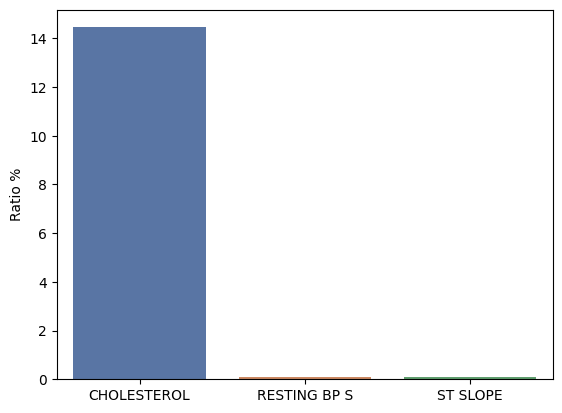

In [14]:
df['CHOLESTEROL'] = df['CHOLESTEROL'].replace(0, np.nan)
df['RESTING BP S'] = df['RESTING BP S'].replace(0, np.nan)
df['ST SLOPE'] = df['ST SLOPE'].replace(0, np.nan)

nullDF = null_counts(df)

sns.barplot(x=nullDF.index.tolist(), y=nullDF["Ratio %"], palette='deep')
plt.show()

In [15]:
df = df.dropna(subset=['ST SLOPE'])

In [16]:
##### *Tahmine Dayalı Değer Atama Yöntemi*

In [17]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [18]:
##### *Aykırı Değer Analizi*

--- 
AGE 
---


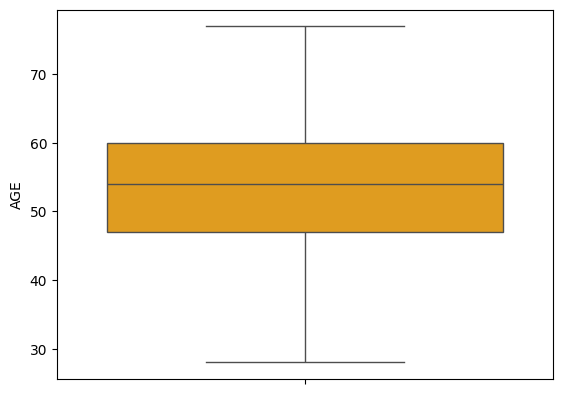

----------- 
CHOLESTEROL 
-----------


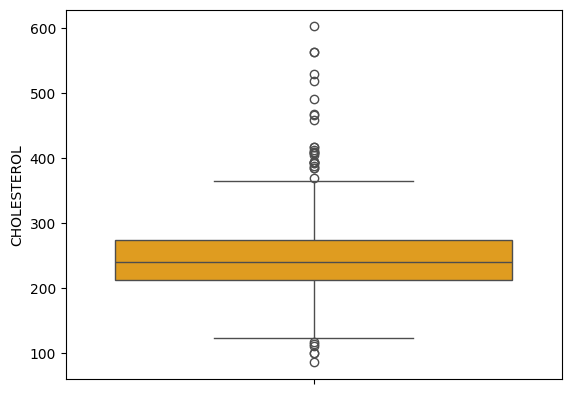

-------------- 
MAX HEART RATE 
--------------


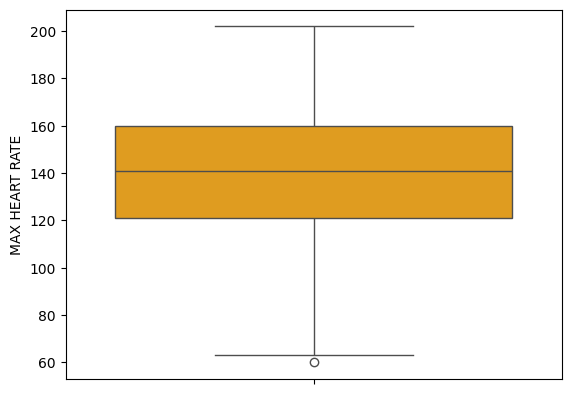

------- 
OLDPEAK 
-------


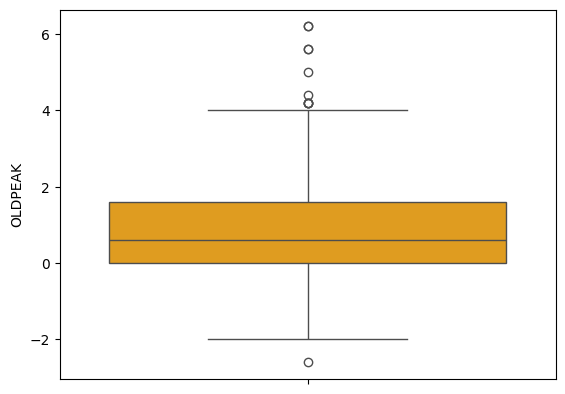

------------ 
RESTING BP S 
------------


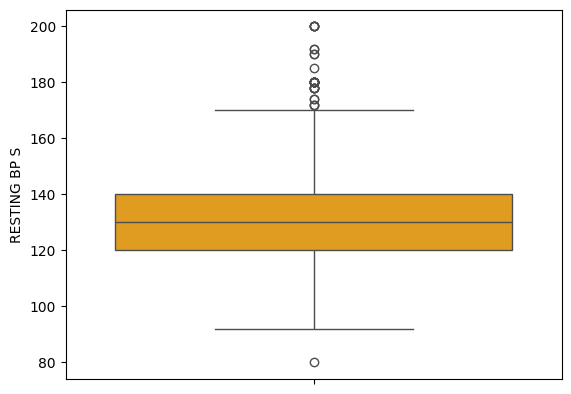

In [19]:
for col in num_cols:
        printTitle(col)
        sns.boxplot(df[col], color='orange')
        plt.show()

In [20]:
##### *Aykırı değerlerin baskılanması*

In [21]:
for col in num_cols:
    print(col, check_outlier(df, col, q1=0.05, q3=0.95))
    if check_outlier(df, col):
        replace_with_thresholds(df, col, q1=0.05, q3=0.95)

AGE False
CHOLESTEROL True
MAX HEART RATE False
OLDPEAK False
RESTING BP S False


In [22]:
##### *Feature Extraction (Özellik Çıkarımı)*

In [23]:
df['NEW AGE'] = pd.cut(df['AGE'],
                       bins=[0, 12, 19, 35, 60, 100],
                       labels=['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior'])

df['NEW CHOLESTEROL'] = pd.cut(df['CHOLESTEROL'],
                               bins=[0, 200, 239, 279, 500],
                               labels=['Desirable', 'Borderline High', 'High', 'Very High'])

df['NEW RESTING BP S'] = pd.cut(df['RESTING BP S'],
                               bins=[0, 90, 120, 130, 140, 180, 300],
                               labels=['Low', 'Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertensive Crisis'])

df['NEW MAX HEART RATE BASED ON AGE'] = df["MAX HEART RATE"] - df["AGE"]

display(df)

,AGE,SEX,CHEST PAIN TYPE,RESTING BP S,CHOLESTEROL,FASTING BLOOD SUGAR,RESTING ECG,MAX HEART RATE,EXERCISE ANGINA,OLDPEAK,ST SLOPE,TARGET,NEW AGE,NEW CHOLESTEROL,NEW RESTING BP S,NEW MAX HEART RATE BASED ON AGE
0,40.0,1.0,2.0,140.0,289.0,0.0,0.0,172.0,0.0,0.0,1.0,0.0,Adult,Very High,Hypertension Stage 1,132.0
1,49.0,0.0,3.0,160.0,180.0,0.0,0.0,156.0,0.0,1.0,2.0,1.0,Adult,Desirable,Hypertension Stage 2,107.0
2,37.0,1.0,2.0,130.0,283.0,0.0,1.0,98.0,0.0,0.0,1.0,0.0,Adult,Very High,Elevated,61.0
3,48.0,0.0,4.0,138.0,214.0,0.0,0.0,108.0,1.0,1.5,2.0,1.0,Adult,Borderline High,Hypertension Stage 1,60.0
4,54.0,1.0,3.0,150.0,195.0,0.0,0.0,122.0,0.0,0.0,1.0,0.0,Adult,Desirable,Hypertension Stage 2,68.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1184,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,1.0,Adult,High,Normal,87.0
1185,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,1.0,Senior,Desirable,Hypertension Stage 2,73.0
1186,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,Adult,Desirable,Elevated,58.0
1187,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,Adult,Borderline High,Elevated,117.0


In [24]:
df2 = create_readable_dataframe(df)

In [25]:
##### *GELİŞMİŞ FONKSİYONEL KEŞİFÇİ VERİ ANALİZİ (ADVANCED FUNCTIONAL EDA)*

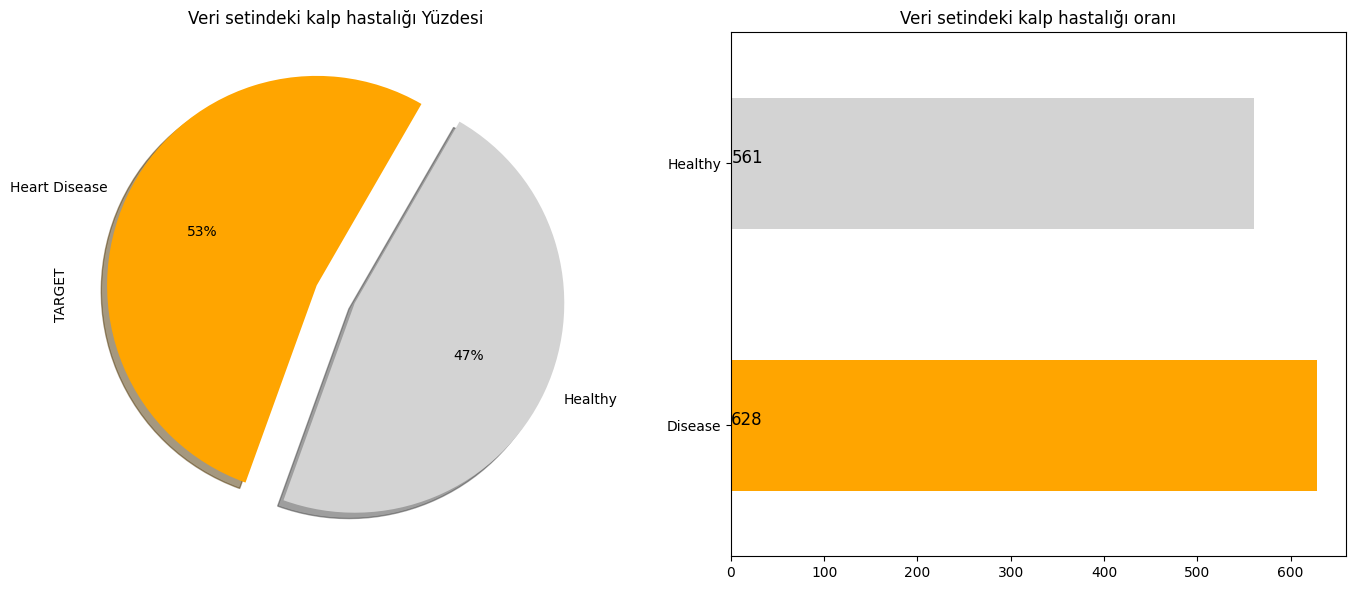

In [26]:
# Plotting attrition of employees
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(14,6))
colors = ['orange', 'lightgray']

ax1 = df2["TARGET"].value_counts().plot.pie( x="Heart disease" ,y ='no.of patients', 
                   autopct = "%1.0f%%",labels=["Heart Disease","Healthy"], startangle = 60,ax=ax1, colors=colors, explode=[.1,.1],shadow =True);
ax1.set(title = 'Veri setindeki kalp hastalığı Yüzdesi')

ax2 = df2["TARGET"].value_counts().plot(kind="barh" ,ax =ax2, color=colors)

for i,j in enumerate(df2["TARGET"].value_counts().values):
    ax2.text(.5,i,j,fontsize=12)
ax2.set(title = 'Veri setindeki kalp hastalığı oranı')
plt.tight_layout()
plt.show()

Veri seti 561 normal hasta ve 629 kalp hastalığı olan hastadan oluşan dengeli bir veri setidir.

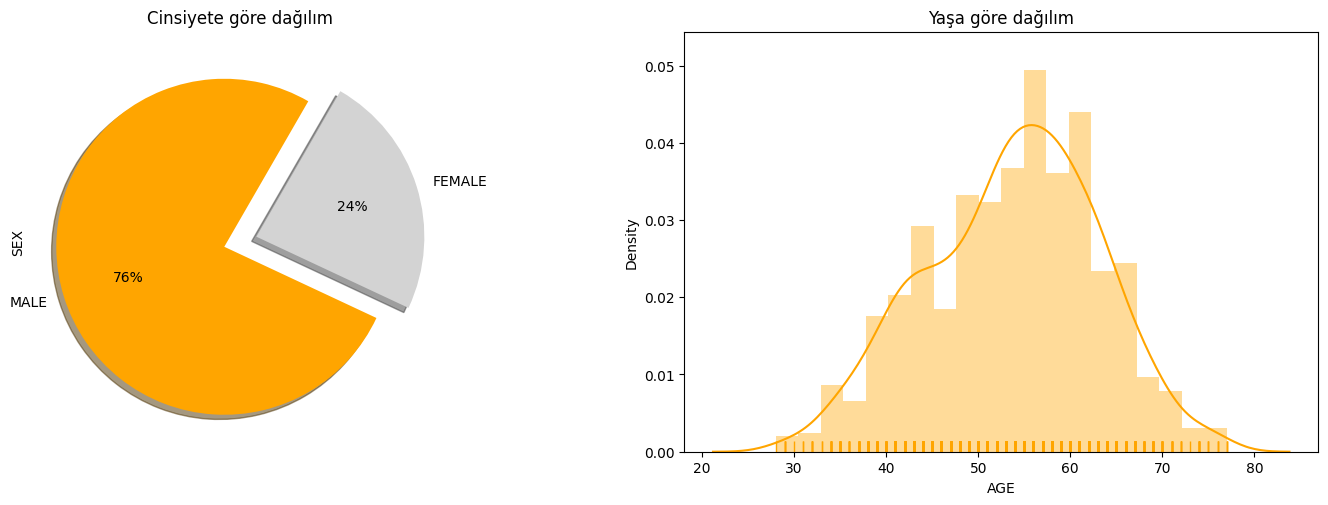

In [27]:
plt.figure(figsize=(18,12))
plt.subplot(221)
df["SEX"].value_counts().plot.pie(autopct = "%1.0f%%",colors =['orange', 'lightgray'],startangle = 60,labels=["MALE","FEMALE"],
explode=[.1,.1],shadow =True)
plt.title("Cinsiyete göre dağılım")
plt.subplot(222)
ax= sns.distplot(df['AGE'], rug=True, color='orange')
plt.title("Yaşa göre dağılım")
plt.show()

Bu veri setinde erkeklerin yüzdesi kadınların yüzdesinden çok daha fazladır ve hastaların ortalama yaşı 55 tir.​

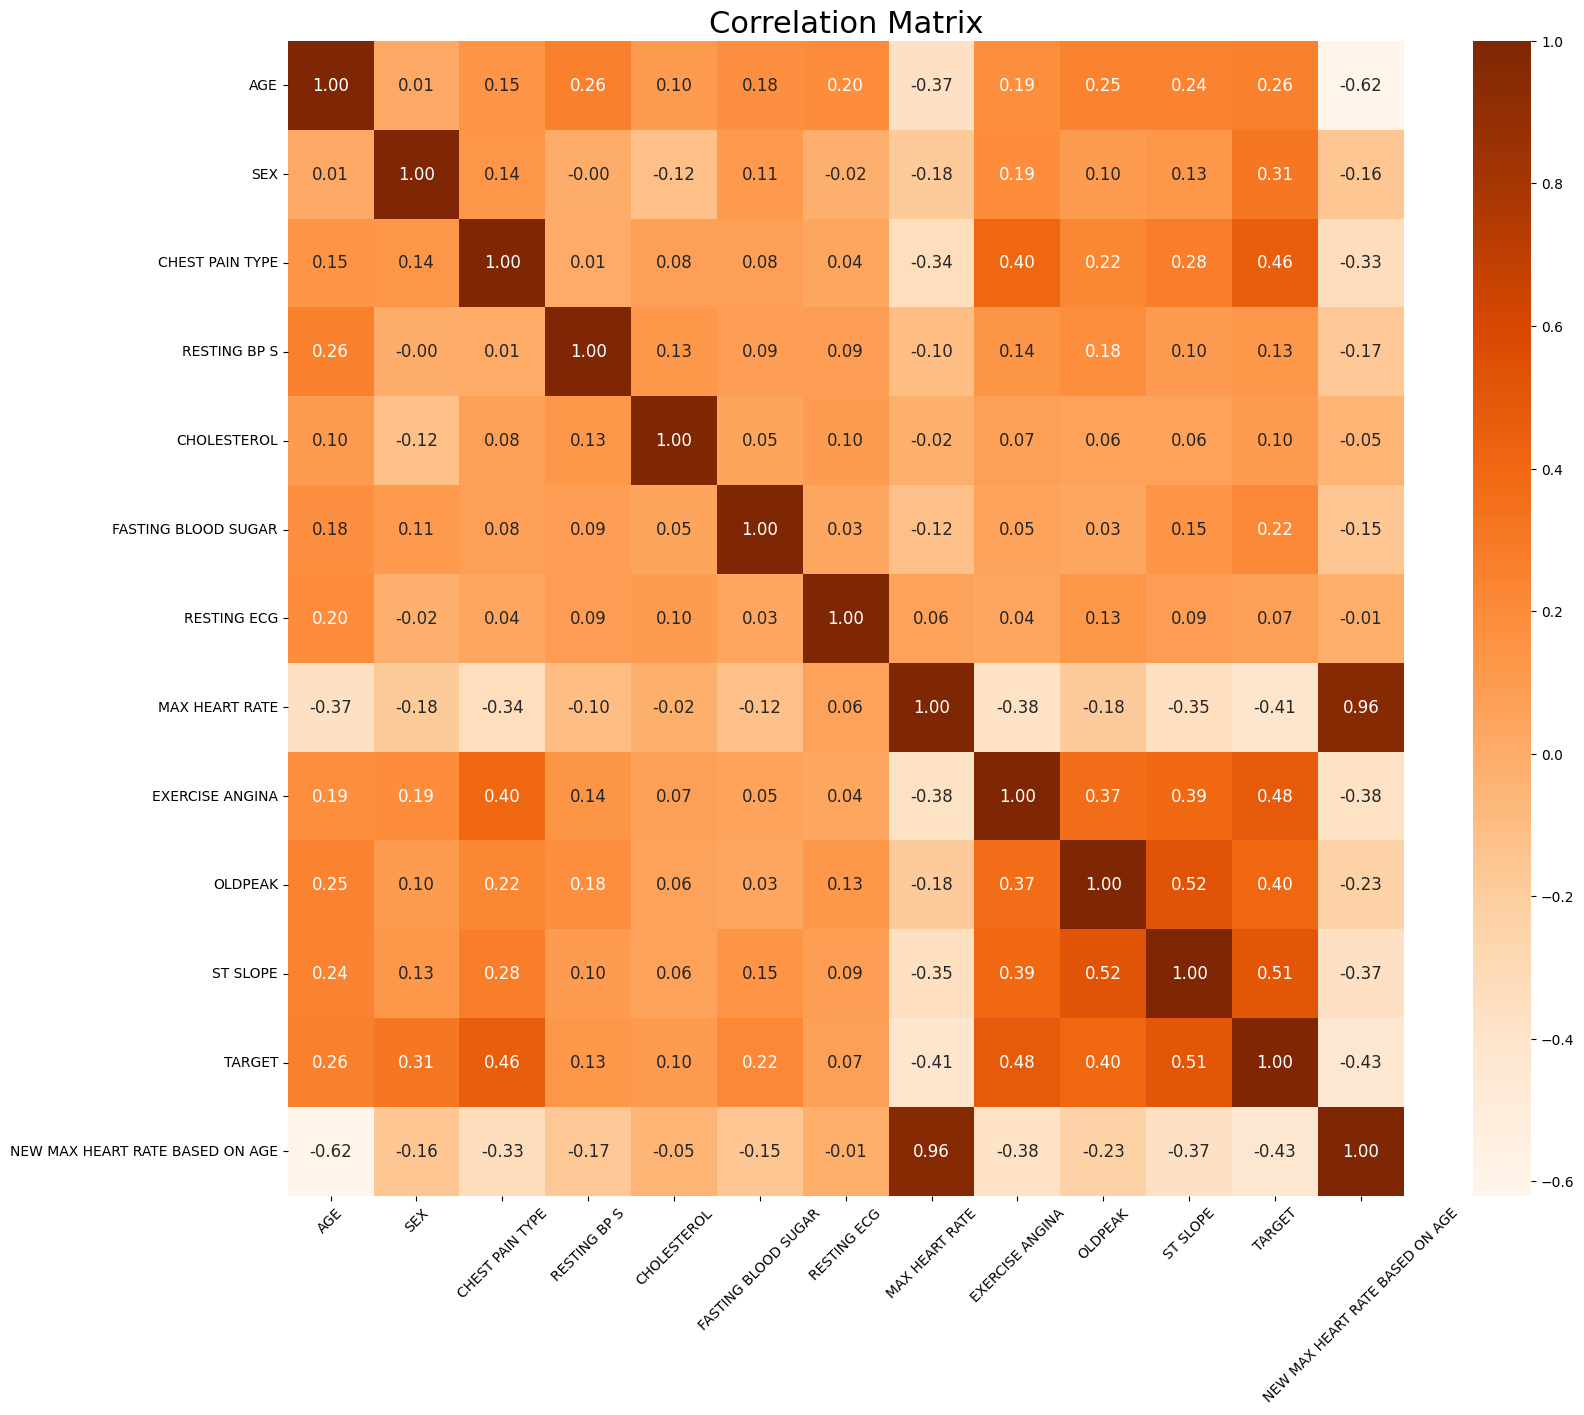

In [28]:
fig, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(df.corr(),
            annot=True,
            fmt=".2f",
            annot_kws={'fontsize': 12},
            cmap='Oranges',
            ax=ax)

ax.set_title("Correlation Matrix", fontsize=22)
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);
plt.show()

In [29]:
corr_matrix = df.corr()
target_corr = pd.DataFrame(corr_matrix.loc[:,"TARGET"])
target_corr["ABS"] = target_corr["TARGET"].abs()
target_high_corrs = target_corr[(target_corr["ABS"] >= 0.3) & (target_corr["ABS"] < 1)].sort_values(by='ABS', ascending=False)
target_high_corrs

,TARGET,ABS
ST SLOPE,0.509433,0.509433
EXERCISE ANGINA,0.482407,0.482407
CHEST PAIN TYPE,0.460509,0.460509
NEW MAX HEART RATE BASED ON AGE,-0.429425,0.429425
MAX HEART RATE,-0.413208,0.413208
OLDPEAK,0.399331,0.399331
SEX,0.310982,0.310982


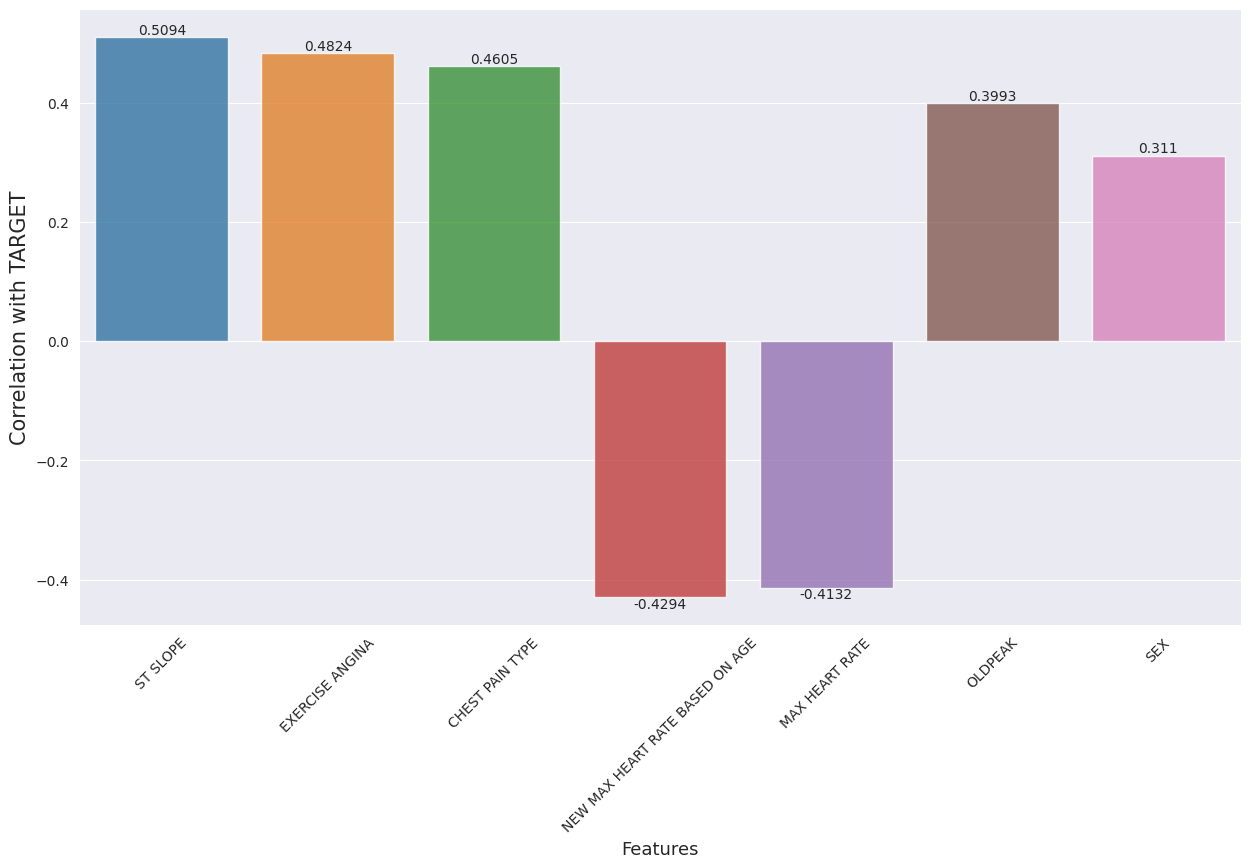

In [30]:
fig = plt.figure(figsize=(15,8))
sns.set_style('darkgrid')
s = sns.barplot(x=target_high_corrs.index.tolist(), y=target_high_corrs["TARGET"].apply(lambda x: round(x, 4)), alpha=.8, palette=sns.color_palette())
[s.bar_label(i, ) for i in s.containers]
plt.xlabel("Features", fontsize=13)
plt.ylabel("Correlation with TARGET", fontsize=15)
s.tick_params(axis='x', rotation=45)
plt.show()

In [31]:
disease=df2[df2['TARGET']=="Disease"]
normal=df2[df2['TARGET']=="Healthy"]

In [32]:
print(disease['CHEST PAIN TYPE'].head())

1     non-anginal pain
3         asymptomatic
8         asymptomatic
11     atypical angina
13        asymptomatic
Name: CHEST PAIN TYPE, dtype: object


##### *Göğüs Ağrısı Tipinin Dağılımı*

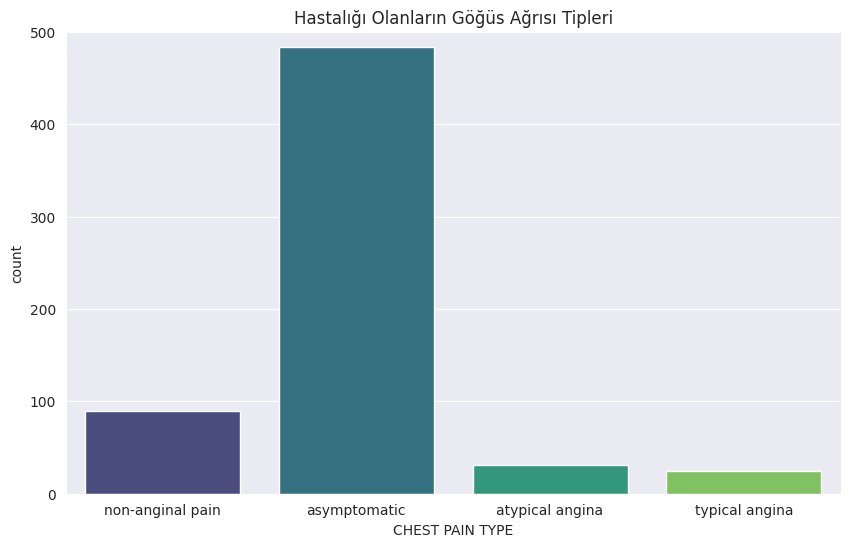

In [33]:
plt.figure(figsize=(10, 6))
sns.countplot(data=disease, x='CHEST PAIN TYPE', palette='viridis')
plt.title('Hastalığı Olanların Göğüs Ağrısı Tipleri')
plt.ylim(0, 500)
plt.show()

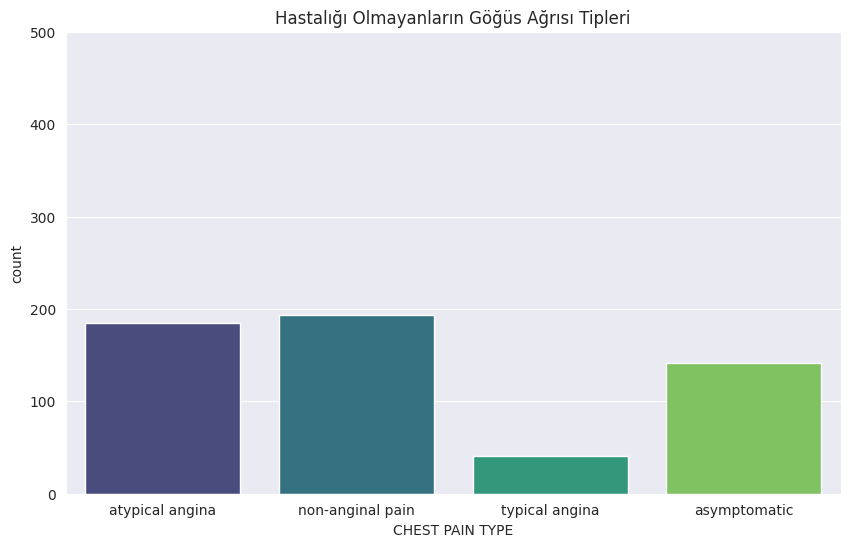

In [34]:
plt.figure(figsize=(10, 6))
sns.countplot(data=normal, x='CHEST PAIN TYPE', palette='viridis')
plt.title('Hastalığı Olmayanların Göğüs Ağrısı Tipleri')
plt.ylim(0, 500)
plt.show()

##### *Hastalığı olmayanların Yaşları ve Cinsiyetleri*

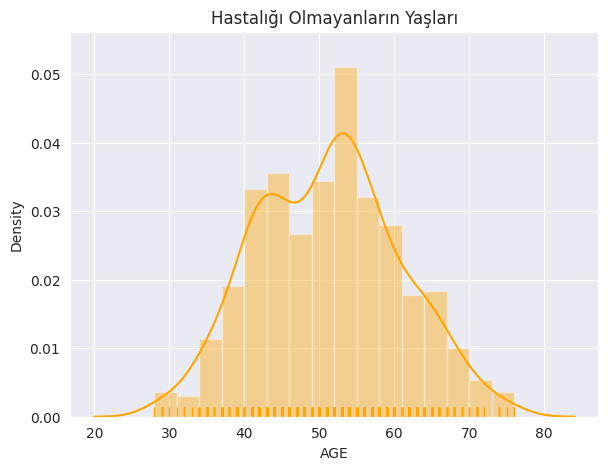

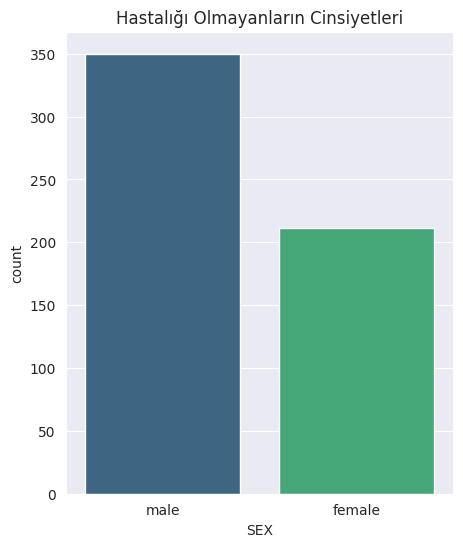

In [35]:
# plotting normal patients
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2),(0,0))
sns.distplot(normal['AGE'], rug=True, color='orange')
plt.title('Hastalığı Olmayanların Yaşları')

plt.figure(figsize=(5, 6))
sns.countplot(data=normal, x='SEX', palette='viridis')
plt.title('Hastalığı Olmayanların Cinsiyetleri')
plt.show()

##### *Hastalığı olanların Yaşları ve Cinsiyetleri*

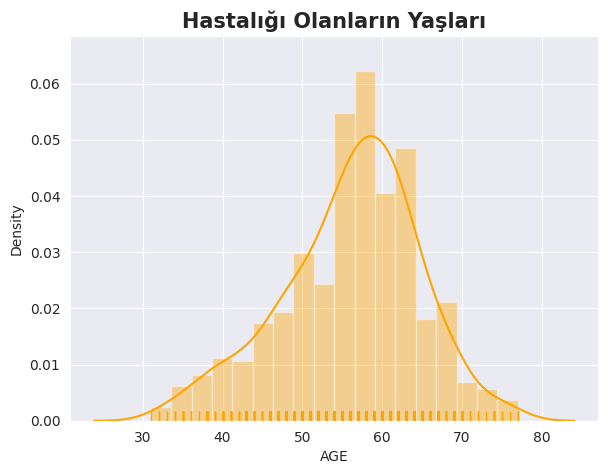

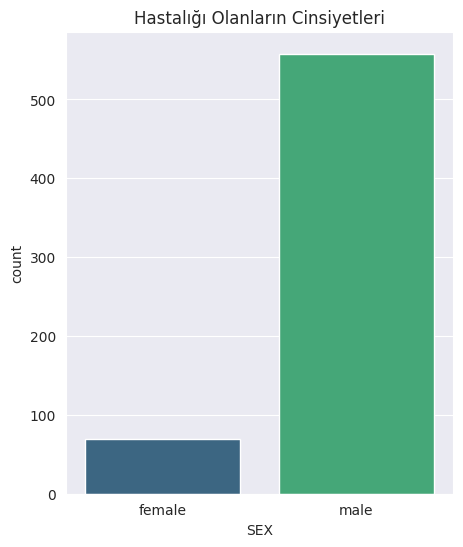

In [36]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2),(0,0))
sns.distplot(disease['AGE'], rug=True, color='orange')
plt.title('Hastalığı Olanların Yaşları', fontsize=15, weight='bold')

plt.figure(figsize=(5, 6))
sns.countplot(data=disease, x='SEX', palette='viridis')
plt.title('Hastalığı Olanların Cinsiyetleri')
plt.show()

Kalp hastalığı olan hastaların ortalama yaşı 58 ila 60 yaş civarındadır.

##### *Dinlenme EKG Dağılımı*

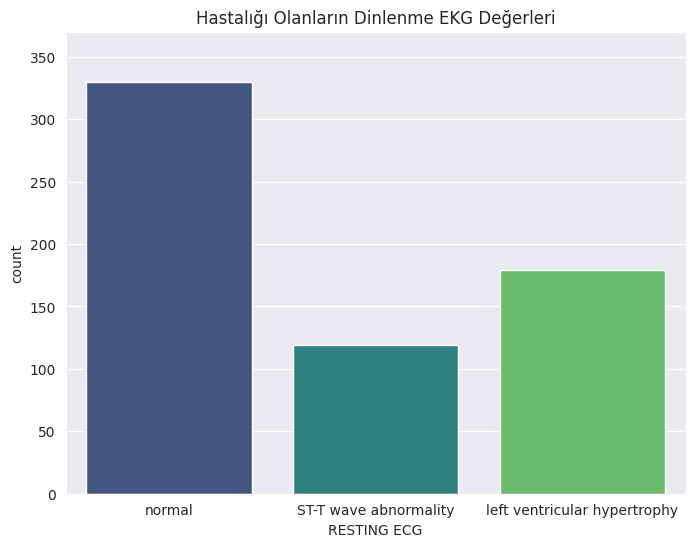

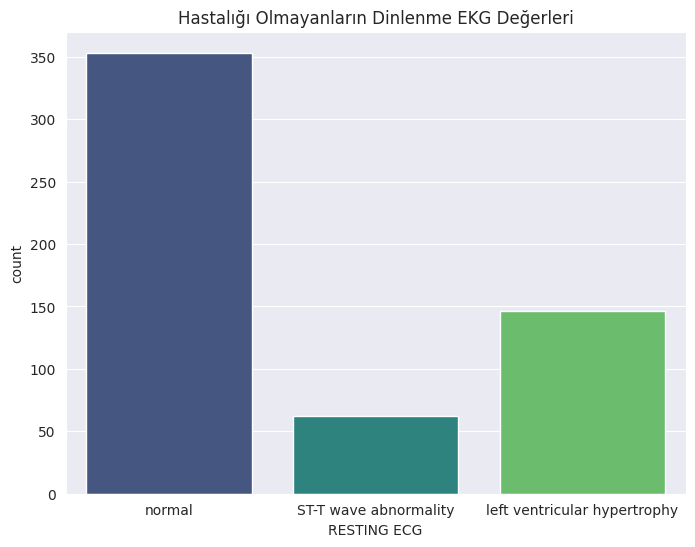

In [37]:
plt.figure(figsize=(8, 6))
sns.countplot(data=disease, x='RESTING ECG', palette='viridis')
plt.ylim(0, 370)
plt.title('Hastalığı Olanların Dinlenme EKG Değerleri')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(data=normal, x='RESTING ECG', palette='viridis')
plt.ylim(0, 370)
plt.title('Hastalığı Olmayanların Dinlenme EKG Değerleri')
plt.show()

##### *ST SLOPE değişkeni* 

In [38]:
df2['ST SLOPE'].unique()

array(['upsloping', 'flat', 'downsloping'], dtype=object)

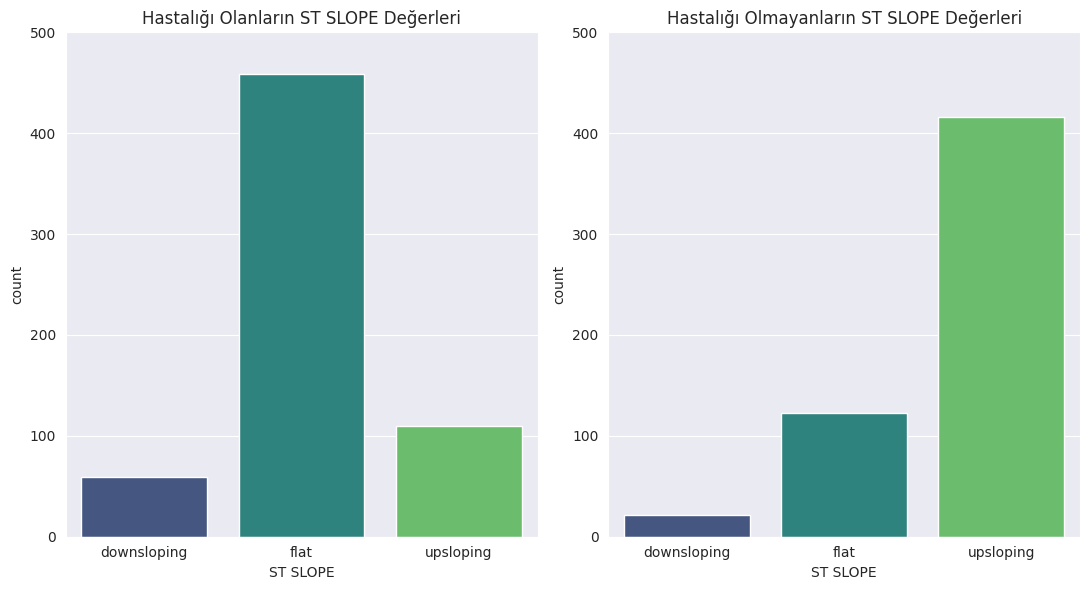

In [39]:
fig,axs=plt.subplots(1,2, figsize=(11, 6))

for index, model in enumerate([disease, normal]):
    sns.countplot(data=model, x='ST SLOPE', palette='viridis', ax=axs[index],
                 order=['downsloping', 'flat', 'upsloping'])
    axs[index].set_title(['Hastalığı Olanların ST SLOPE Değerleri', 'Hastalığı Olmayanların ST SLOPE Değerleri'][index])
    axs[index].set_ylim(0, 500)

plt.tight_layout()

plt.show()


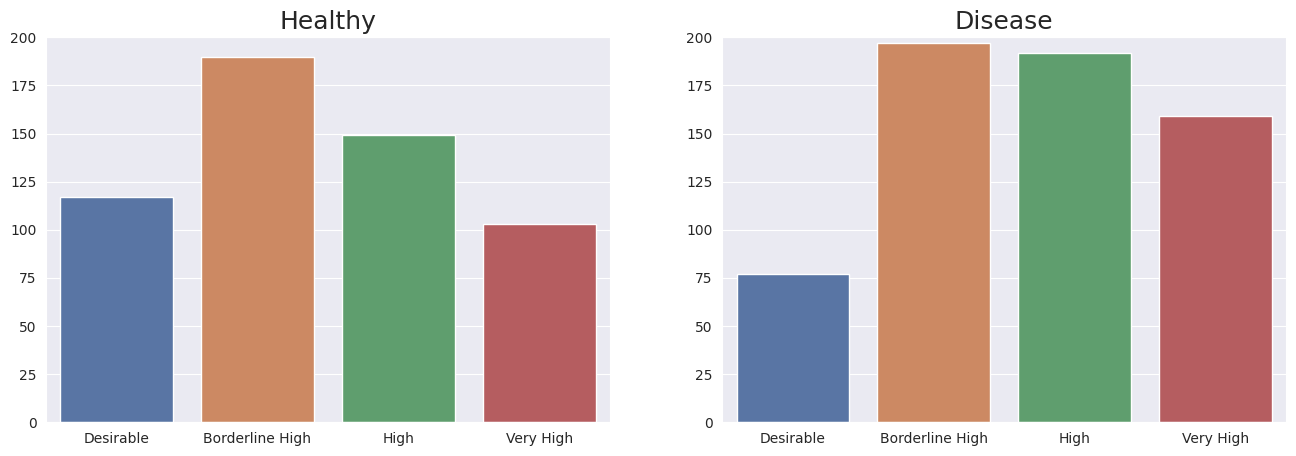

In [40]:
fig,axs=plt.subplots(1,2, figsize=(16, 5))
titles=["Healthy", "Disease"]
for i, value in enumerate(titles):
    sns.countplot(data=df2[df2.TARGET == value], x="NEW CHOLESTEROL", palette='deep',ax=axs[i])
    axs[i].set_xlabel("", fontsize=15)
    axs[i].set_ylabel("", fontsize=15)
    axs[i].set_title(value, fontsize=18)
    axs[i].set_ylim(0, 200)
fig.show()

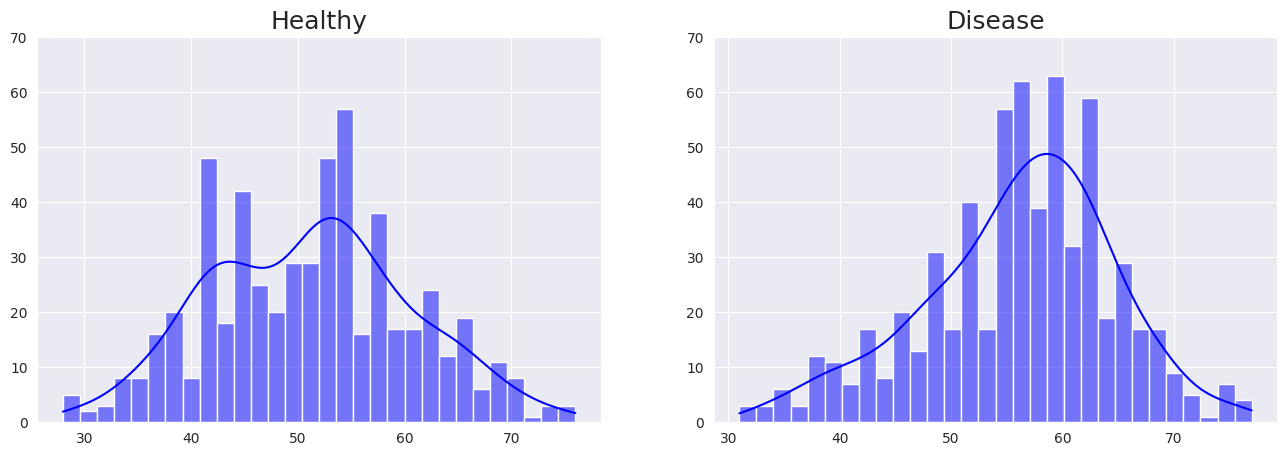

In [42]:
fig,axs=plt.subplots(1,2, figsize=(16, 5))
titles=["Healthy", "Disease"]
for i, value in enumerate(titles):
    sns.histplot(data=df2[df2.TARGET == value]["AGE"], bins=30, kde=True, color='blue',ax=axs[i])
    axs[i].set_xlabel("", fontsize=15)
    axs[i].set_ylabel("", fontsize=15)
    axs[i].set_title(value, fontsize=18)
    axs[i].set_ylim(0, 70)
fig.show()

##### *Sayısal Özelliklerin Dağılımı*

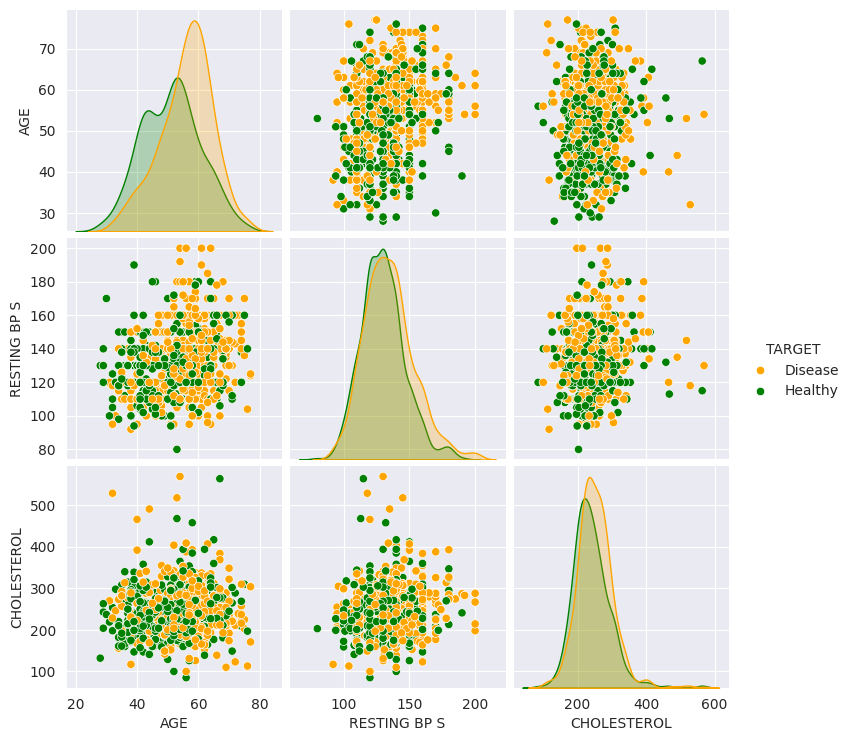

In [43]:
sns.pairplot(df2, hue = 'TARGET', vars = ['AGE', 'RESTING BP S', 'CHOLESTEROL'], palette=['orange', 'green'] )

##### Yaş arttıkça kalp hastalığının arttığı görülmektedir.

##### *One-Hot Encoding*

In [44]:
df = pd.get_dummies(df, columns=['CHEST PAIN TYPE', 'RESTING ECG', 'NEW AGE', 'NEW CHOLESTEROL', 'NEW RESTING BP S'], drop_first=True)

In [45]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=110)

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('---')
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (891, 27)
y_train:  (891,)
---
X_test:  (298, 27)
y_test:  (298,)


##### *Feature Scaling (Özellik Ölçeklendirme)*

In [47]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)


##### *Base Models*

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


models = [('LR', LogisticRegression(random_state=42)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=42)),
          ('RF', RandomForestClassifier(random_state=42)),
          ('SVC', SVC(gamma='auto', random_state=42)),
          ('XGBoost', XGBClassifier(random_state=42)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=42)),
          ("LightGBM", LGBMClassifier(random_state=42, verbosity=-1))]

##### *Model Değerlendirme*

In [49]:
from sklearn.model_selection import cross_validate, GridSearchCV

scores=["Accuracy","Roc Auc","Recall","Precision","F1"]
results = dict(zip(scores,[[], [], [], [], []]))
for name, model in models:
    cv_results = cross_validate(model, scaled_X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=5), scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    results["Accuracy"].append(round(cv_results['test_accuracy'].mean(), 4))
    results["Roc Auc"].append(round(cv_results['test_roc_auc'].mean(), 4))
    results["Recall"].append(round(cv_results['test_recall'].mean(), 4))
    results["Precision"].append(round(cv_results['test_precision'].mean(), 4))
    results["F1"].append(round(cv_results['test_f1'].mean(), 4))

models_scores = pd.DataFrame(results, columns=scores, index=[i[0] for i in models])
models_scores = models_scores.sort_values(by='Accuracy', ascending=False)
models_scores

,Accuracy,Roc Auc,Recall,Precision,F1
RF,0.8979,0.9554,0.9025,0.9056,0.9033
CatBoost,0.8979,0.9521,0.9089,0.8997,0.9035
XGBoost,0.8901,0.9483,0.8876,0.9033,0.8948
LightGBM,0.8833,0.9464,0.8897,0.8901,0.8895
CART,0.8653,0.8660,0.8558,0.8873,0.8702
SVC,0.8552,0.9278,0.8749,0.8567,0.8642
LR,0.8418,0.9112,0.8664,0.8398,0.8521
KNN,0.8036,0.8763,0.8367,0.8020,0.8183


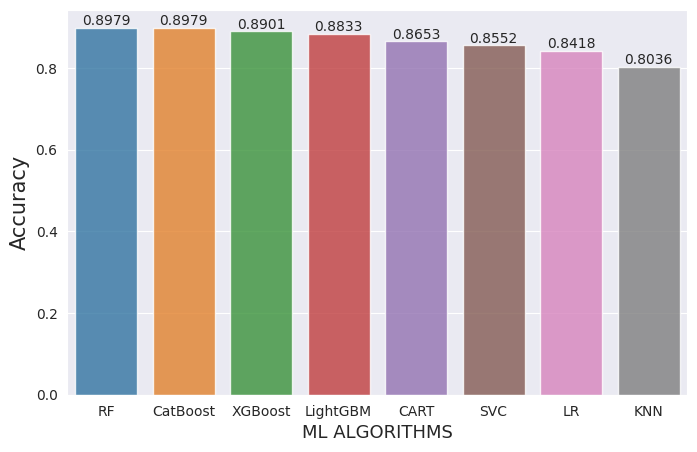

In [50]:
BarChartForScores(models_scores, "Accuracy")

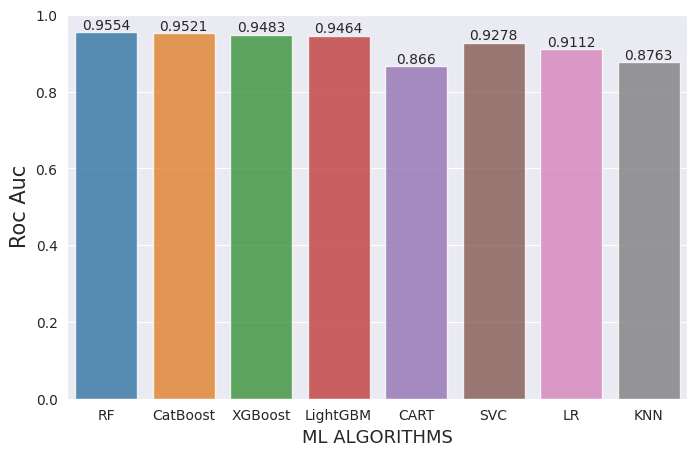

In [51]:
BarChartForScores(models_scores, "Roc Auc")

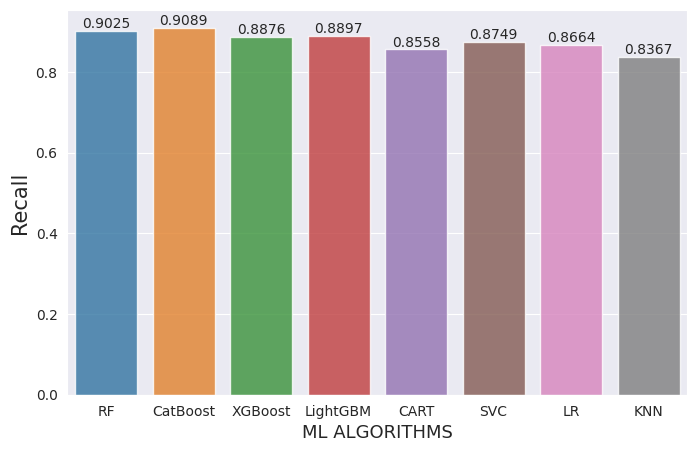

In [52]:
BarChartForScores(models_scores, "Recall")

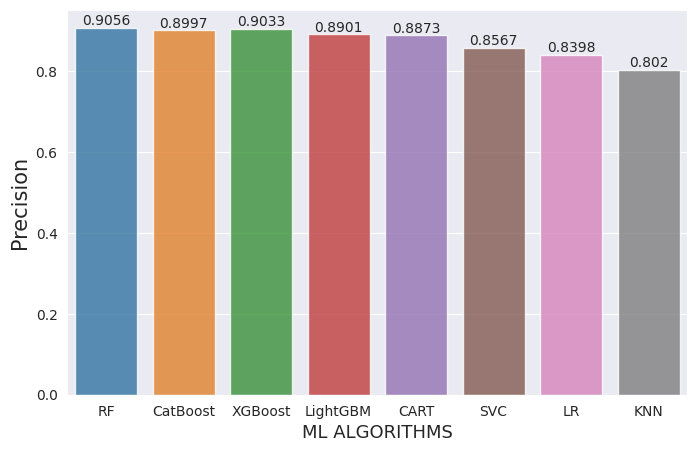

In [53]:
BarChartForScores(models_scores, "Precision")

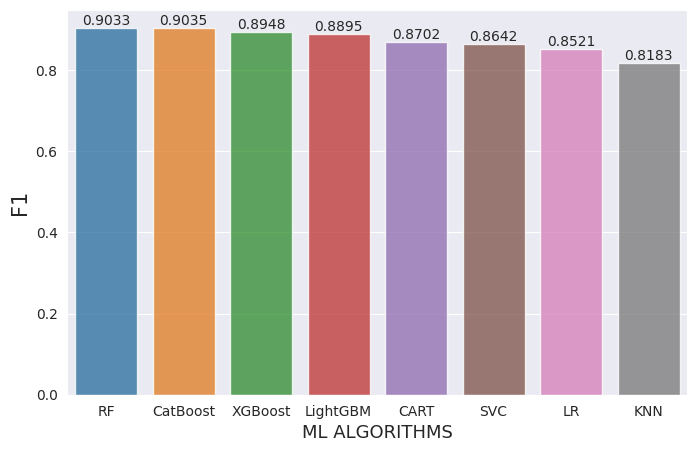

In [54]:
BarChartForScores(models_scores, "F1")

In [55]:
catboost_params = {"iterations": [200,300,400],
                   "learning_rate": [0.01, 0.05, 0.1],
                   "depth": [5, 7, 9]}

xgboost_params = {"learning_rate": [0.1, 0.02, 0.03],
                  "max_depth": [9,10,11],
                  "n_estimators": [100, 150, 200],
                  "colsample_bytree": [0.7, 0.75, 0.8]}

rf_params = {"criterion":["entropy","gini"],
             "max_depth": [16, 17, 18, None],
             "max_features": [3, 5, 8, "auto"],
             "min_samples_split": [2, 3, 5],
             "n_estimators": [200, 300, 400]}

classifiers = [("CatBoost", CatBoostClassifier(verbose=False, random_state=42), catboost_params),
               ('XGBoost', XGBClassifier(eval_metric='logloss', random_state=42), xgboost_params),
               ("RF", RandomForestClassifier(random_state=42), rf_params)]

##### *Automated Hyperparameter Optimization*

In [56]:
def hyperparameter_optimization(X, y, cv=5, scoring="recall"):
    printTitle("Hyperparameter Optimization")
    best_models = {}
    for name, classifier, params in classifiers:
        printTitle(name)
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)
        

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

best_models = hyperparameter_optimization(scaled_X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=5))

--------------------------- 
Hyperparameter Optimization 
---------------------------
-------- 
CatBoost 
--------
recall (Before): 0.9089
recall (After): 0.9173
CatBoost best params: {'depth': 5, 'iterations': 400, 'learning_rate': 0.1}

------- 
XGBoost 
-------
recall (Before): 0.8876
recall (After): 0.9088
XGBoost best params: {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100}

-- 
RF 
--
recall (Before): 0.9025
recall (After): 0.9152
RF best params: {'criterion': 'gini', 'max_depth': 17, 'max_features': 5, 'min_samples_split': 2, 'n_estimators': 300}



##### *Analyzing Model Complexity with Learning Curves*

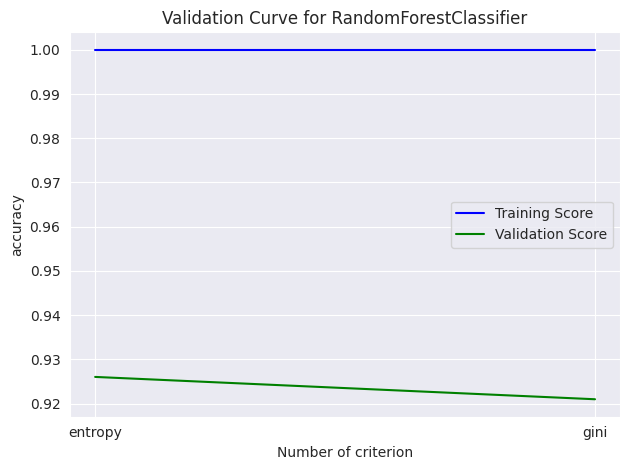

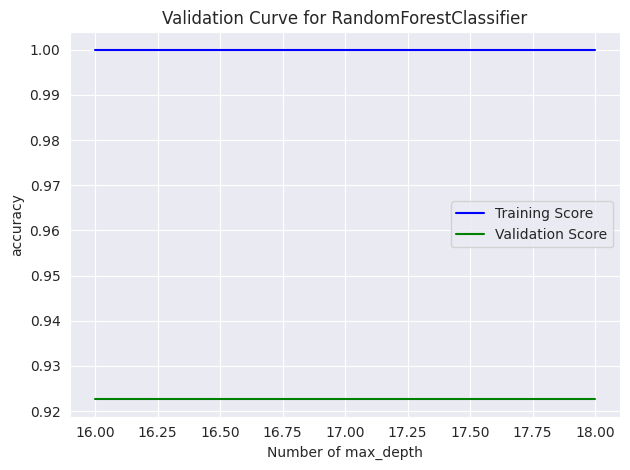

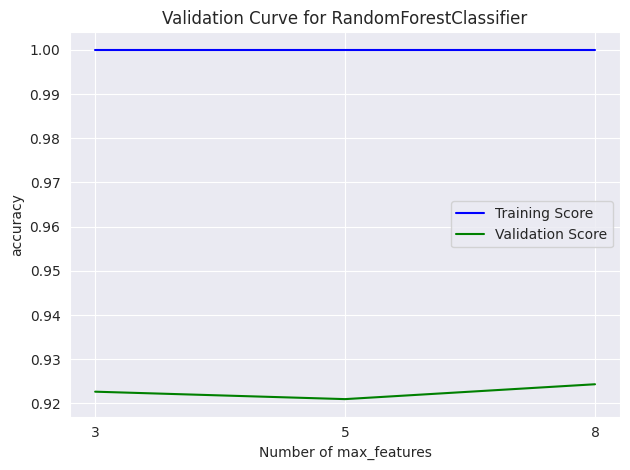

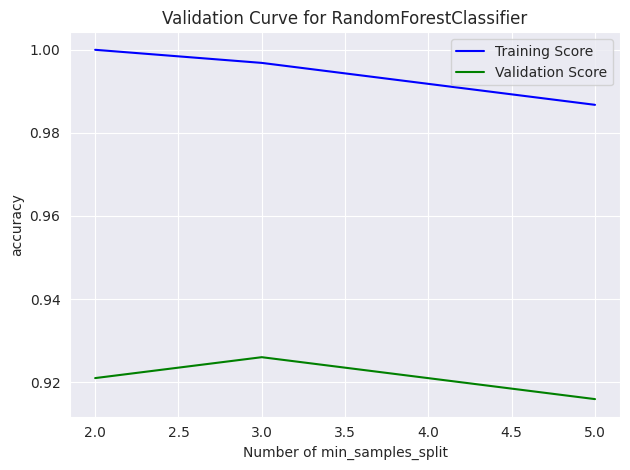

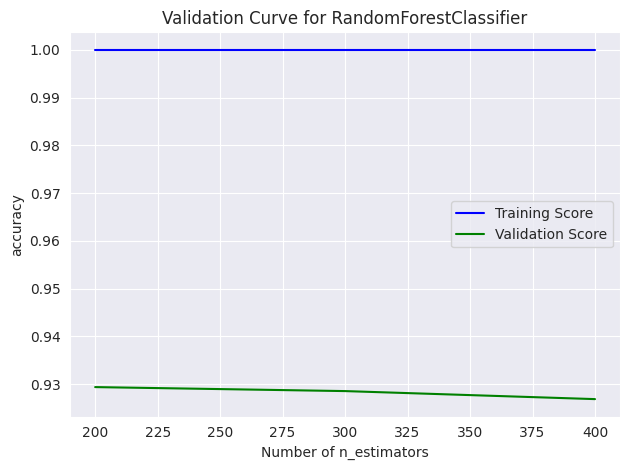

In [57]:
for i in range(len(rf_params)):
    val_curve_params(RandomForestClassifier(random_state=42), X, y, list(rf_params)[i], list(rf_params.values())[i], scoring="accuracy")

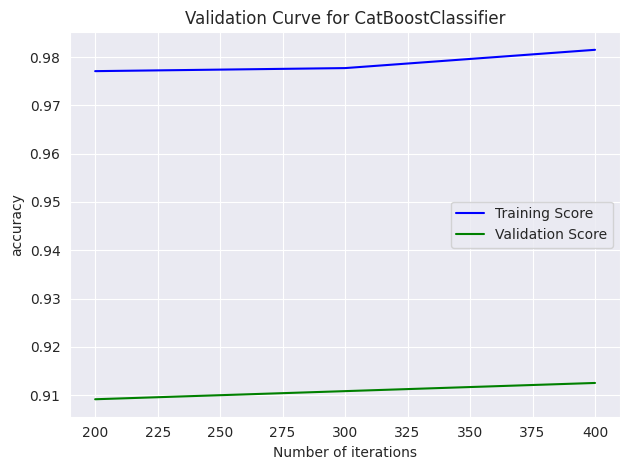

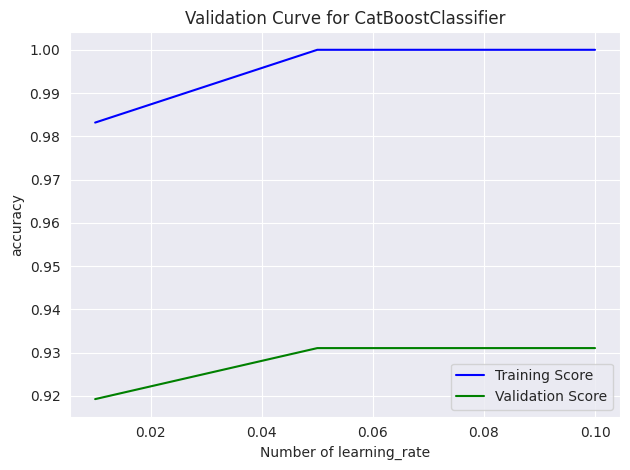

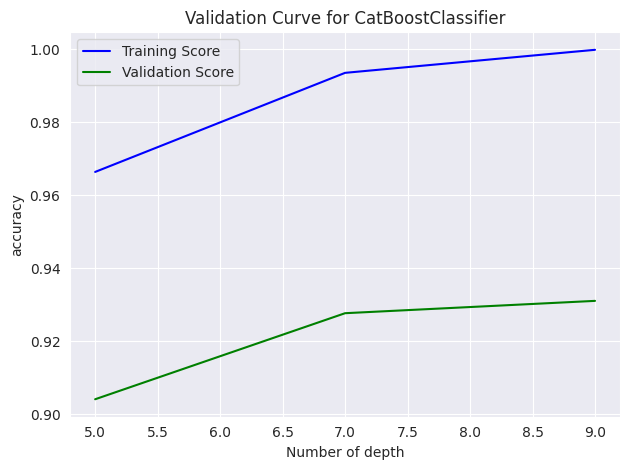

In [58]:
for i in range(len(catboost_params)):
    val_curve_params(CatBoostClassifier(verbose=False, random_state=42), X, y, list(catboost_params)[i], list(catboost_params.values())[i], scoring="accuracy")

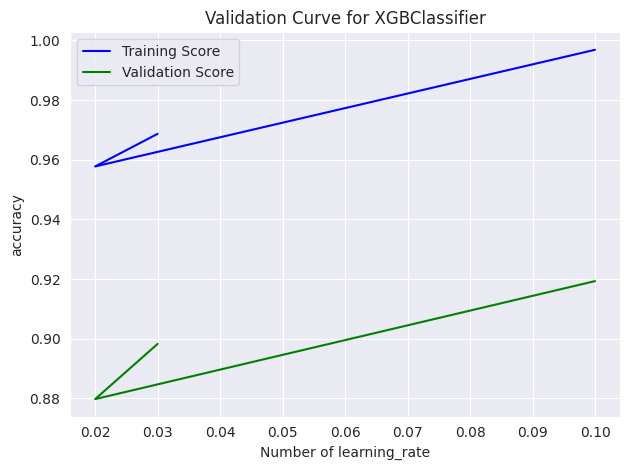

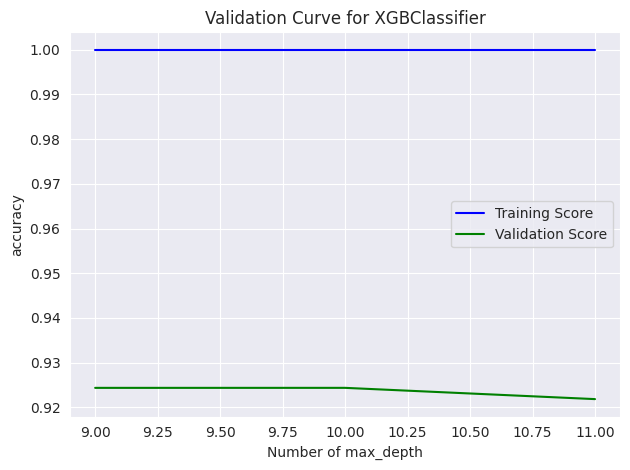

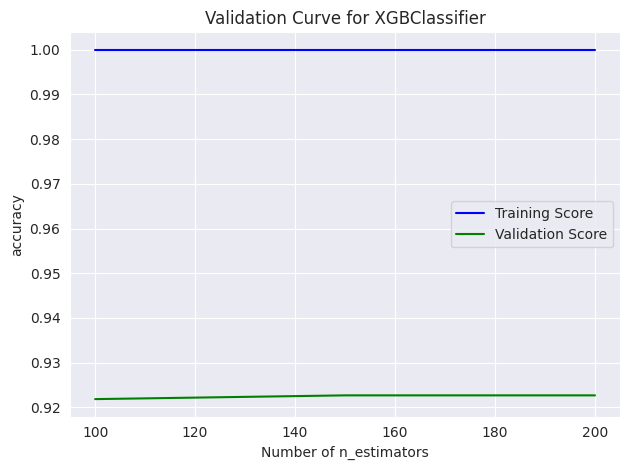

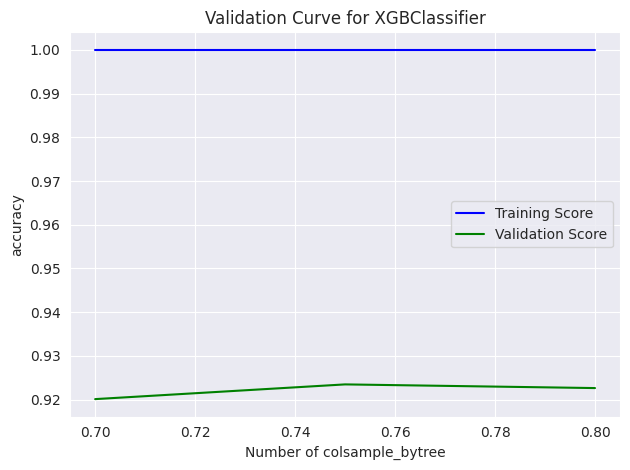

In [59]:
for i in range(len(xgboost_params)):
    val_curve_params(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), X, y,list(xgboost_params)[i], list(xgboost_params.values())[i],scoring="accuracy")

In [60]:
best_models_scores = pd.DataFrame(columns=['Accuracy', 'Roc Auc', 'F1-Score', 'Recall', 'Precision', 'Specificity', 'Log Loss', 'Confusion Matrix', 'False Positive Rate', 'True Positive Rate'])
for model in best_models:
    best_models[model].fit(scaled_X_train, y_train)
    preds = best_models[model].predict(scaled_X_test)
    cm, accuracy, f1, precision, recall = confusion_matrix(y_test, preds), accuracy_score(y_test, preds), f1_score(y_test, preds), precision_score(y_test, preds), recall_score(y_test, preds)

    TN, FN, TP, FP = cm[0][0],  cm[1][0], cm[1][1], cm[0][1]
    specificity = TN/(TN+FP)

    probs = best_models[model].predict_proba(scaled_X_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.to_numpy(), probs[:, 1], pos_label=1)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    log_loss_ = log_loss(y_test, probs)

    best_models_scores.loc[model] = [accuracy, roc_auc, f1, recall, precision, specificity, log_loss_, cm, false_positive_rate, true_positive_rate]

    best_models_scores.iloc[:, :-3] = best_models_scores.iloc[:, :-3].apply(lambda x: round(x, 4))

best_models_scores = best_models_scores.sort_values(by='Accuracy', ascending=False)
best_models_scores[best_models_scores.columns[:-3]]

,Accuracy,Roc Auc,F1-Score,Recall,Precision,Specificity,Log Loss
CatBoost,0.9329,0.9521,0.9367,0.9427,0.9308,0.9220,0.2760
XGBoost,0.9295,0.9551,0.9329,0.9299,0.9359,0.9291,0.2520
RF,0.9228,0.9595,0.9265,0.9236,0.9295,0.9220,0.2683


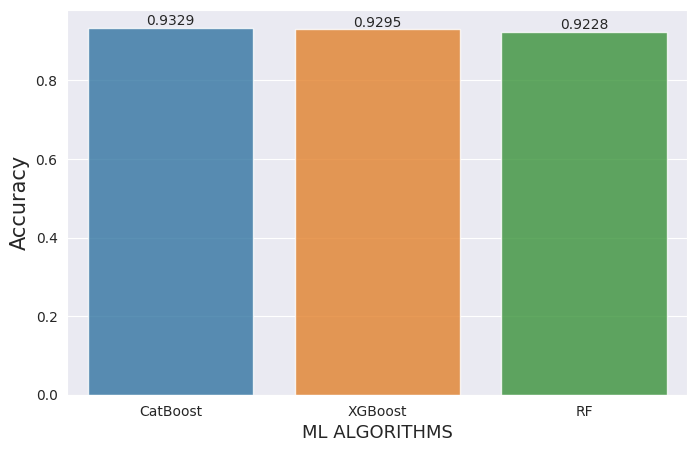

In [61]:
BarChartForScores(best_models_scores, "Accuracy")

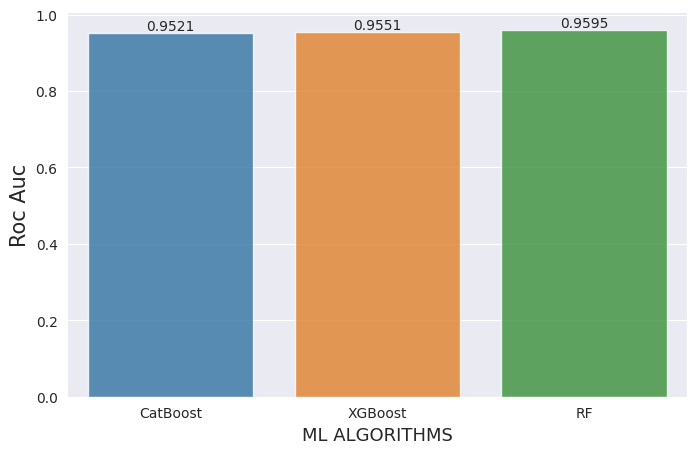

In [62]:
BarChartForScores(best_models_scores, "Roc Auc")

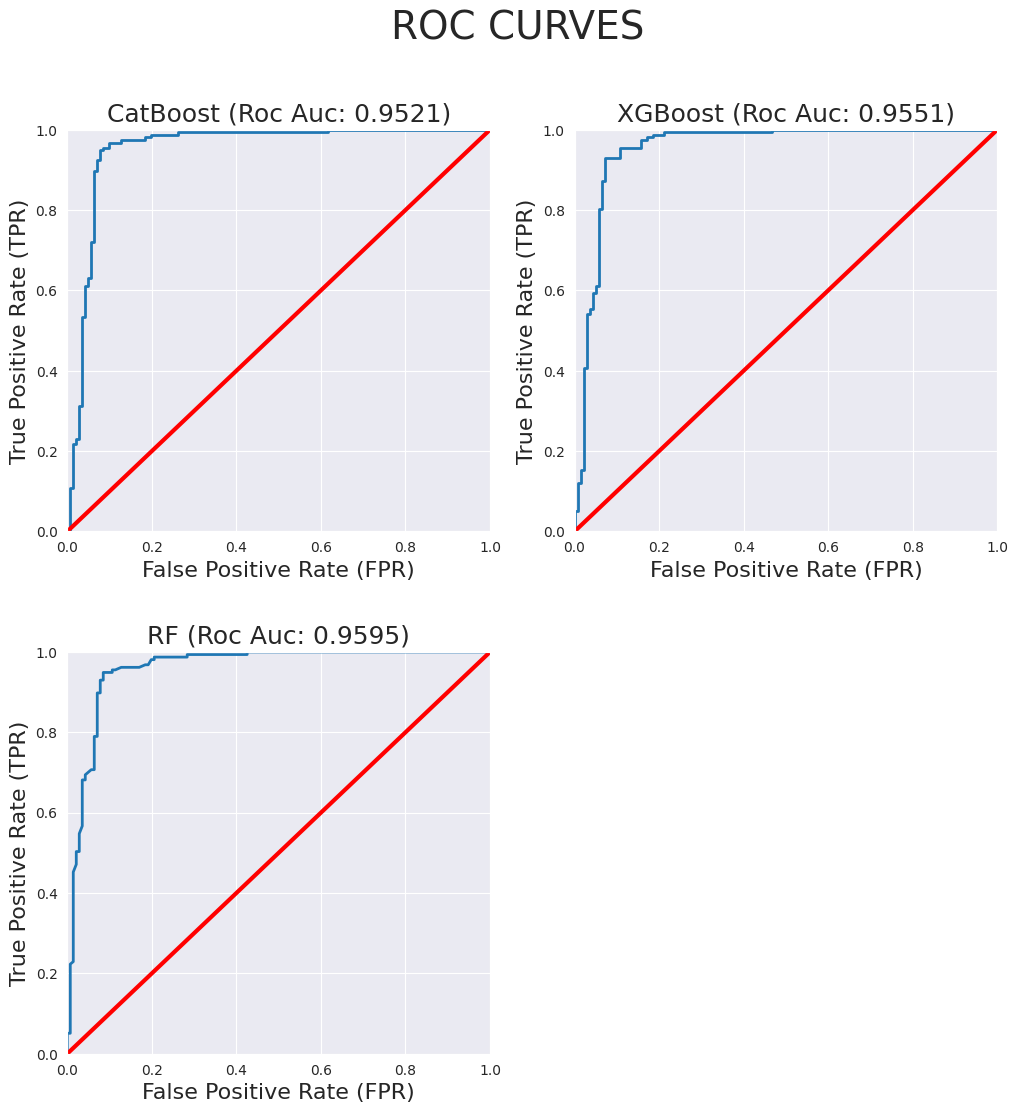

In [63]:
fig,axs=plt.subplots(2,2, figsize=(12, 12))
fig.suptitle("ROC CURVES", fontsize=28)
plt.subplots_adjust(hspace=0.3)

for index, model in enumerate(best_models_scores.index.tolist()):
    ax = axs[index // 2, index % 2]

    ax.plot(best_models_scores.loc[model, 'False Positive Rate'], best_models_scores.loc[model, 'True Positive Rate'], linewidth=2, label='label')
    ax.plot([0, 1], [0, 1], 'r', linewidth=3)
    ax.axis([0, 1, 0, 1])
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=16)
    ax.set_ylabel('True Positive Rate (TPR)', fontsize=16)
    ax.set_title(f"{model} (Roc Auc: {best_models_scores.loc[model, 'Roc Auc']:.4f})", fontsize=18)

axs[1, 1].axis('off')
plt.show()

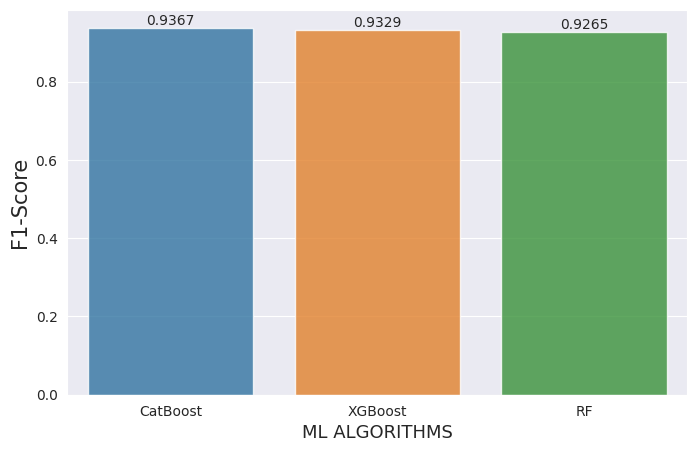

In [64]:
BarChartForScores(best_models_scores, "F1-Score")

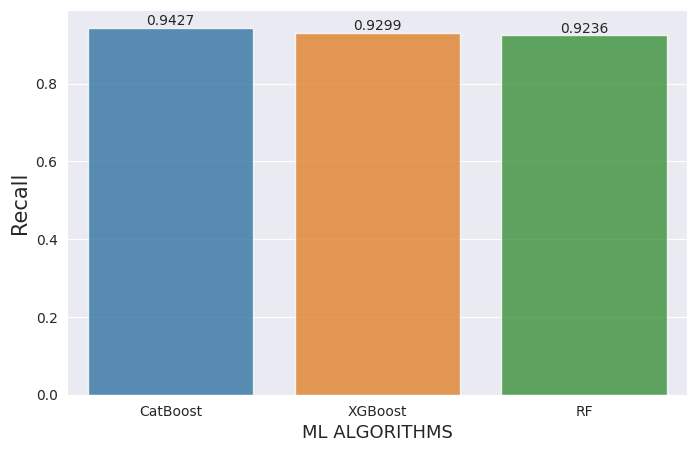

In [65]:
BarChartForScores(best_models_scores, "Recall")

##### *Model Değerlendirme*

In [66]:
Best_Model = RandomForestClassifier(max_depth= 17, max_features=3, min_samples_split=2, n_estimators=500)

In [67]:
Best_Model = best_models["CatBoost"]

In [68]:
Best_Model

In [69]:
pd.DataFrame(best_models_scores.loc["CatBoost"].iloc[:-3])

,CatBoost
Accuracy,0.9329
Roc Auc,0.9521
F1-Score,0.9367
Recall,0.9427
Precision,0.9308
Specificity,0.922
Log Loss,0.276


##### *Karmaşıklık Matrisi*

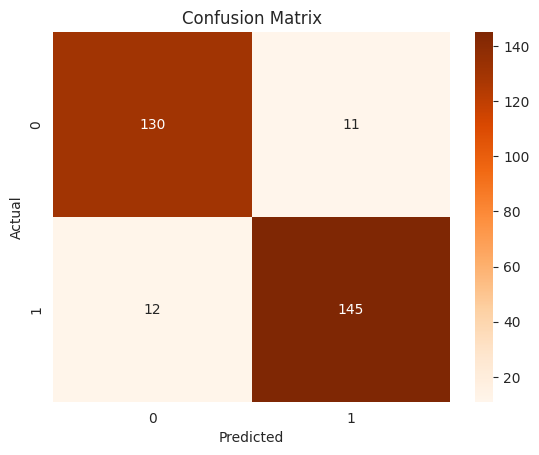

In [70]:
CM = best_models_scores.loc[model, 'Confusion Matrix']
sns.heatmap(CM, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

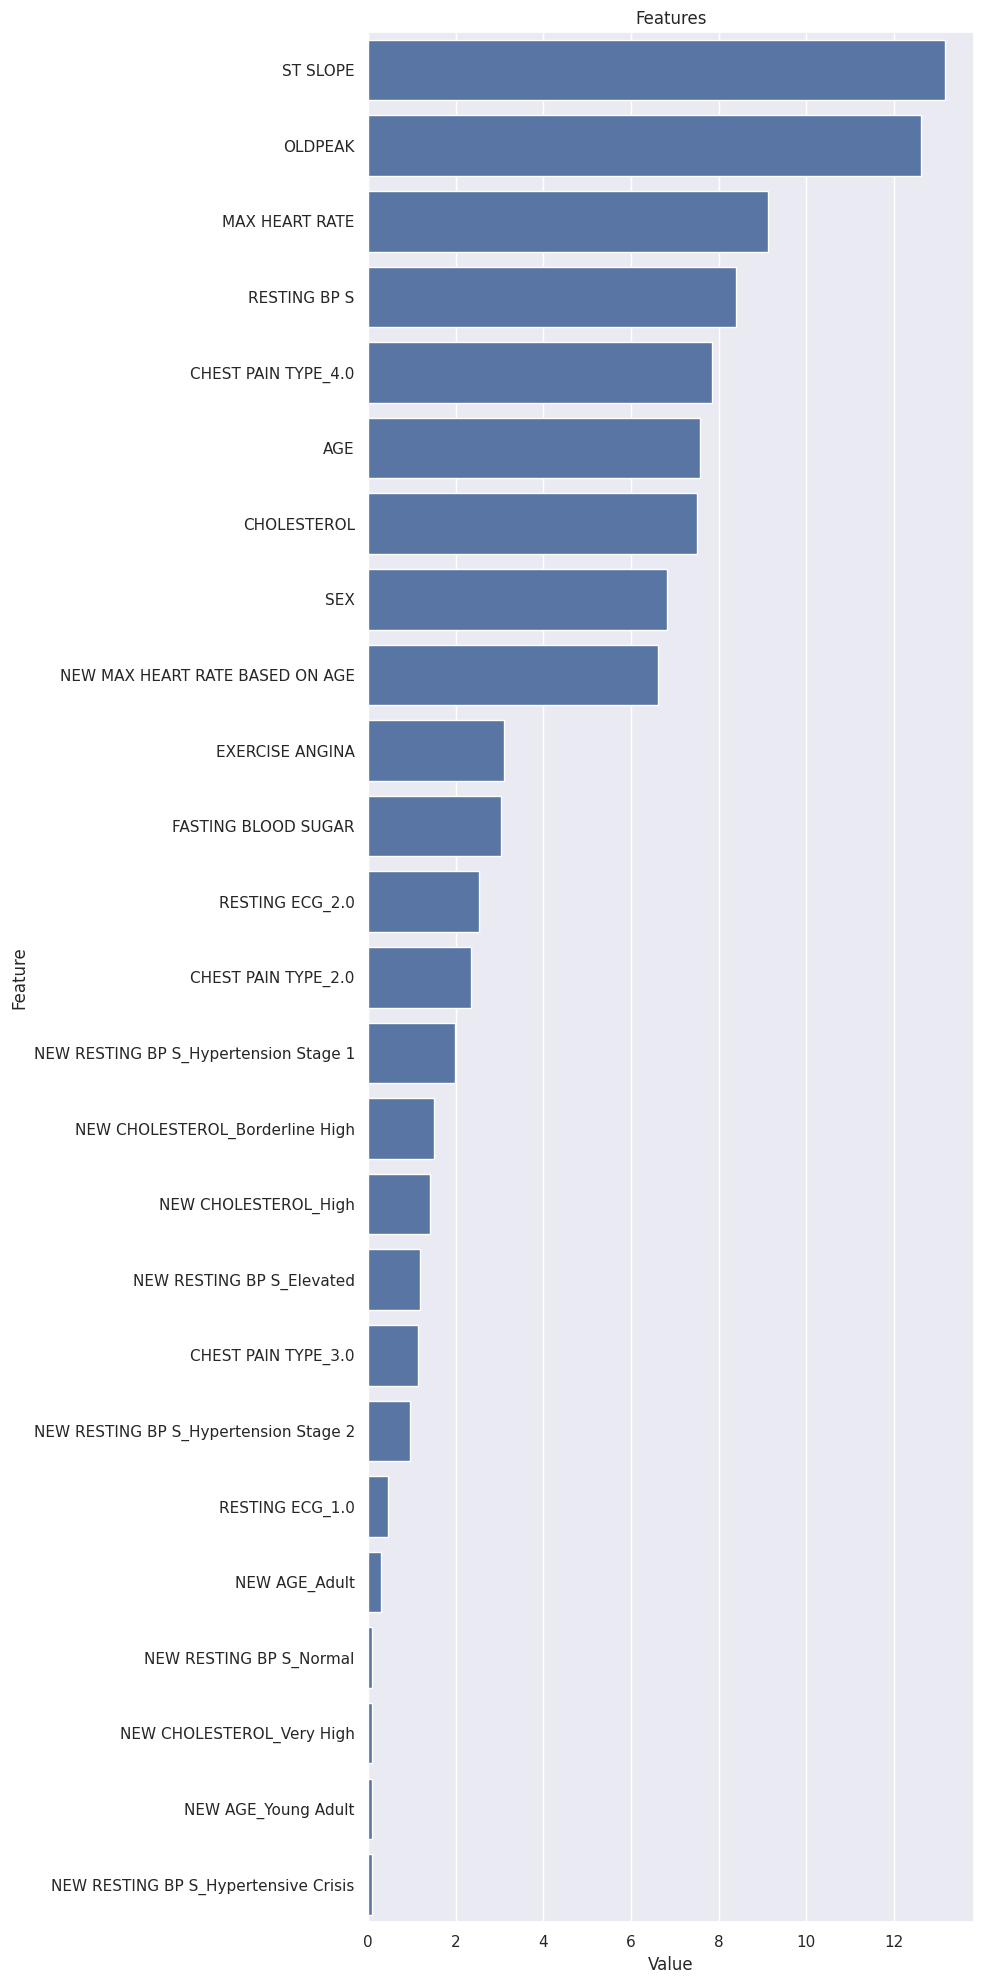

In [71]:
plot_importance(Best_Model, X, 25)

In [72]:
joblib.dump(Best_Model, 'heart_disease_catboost_model.pkl')

['heart_disease_catboost_model.pkl']